# Tutorial 2: Building Inputs with the Functional API

The Functional API provides a traditional approach to generating current inputs through direct function calls. This tutorial covers all functional input types with comprehensive examples.

## Learning Objectives

By the end of this tutorial, you will:
- Master all functional input types in braintools.input
- Understand when to use the functional vs composable API
- Generate complex waveforms and stochastic processes
- Create realistic experimental protocols
- Optimize performance for large-scale simulations

## Setup

In [35]:
import brainstate
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as scipy_signal

import braintools

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11


In [36]:
# Simulation parameters
dt = 0.1 * u.ms
brainstate.environ.set(dt=dt)

In [37]:
def plot_signal(signal, duration, title, ax=None):
    """Helper function to plot signals."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))

    dt_val = u.get_magnitude(dt)
    duration_val = u.get_magnitude(duration)
    time_points = np.arange(0, duration_val, dt_val)
    signal_val = u.get_magnitude(signal)

    ax.plot(time_points, signal_val, 'b-', linewidth=1.5)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Current (nA)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    return ax

## 1. Basic Functional Inputs

The functional API provides direct functions that return current arrays immediately.

### 1.1 Constant Currents

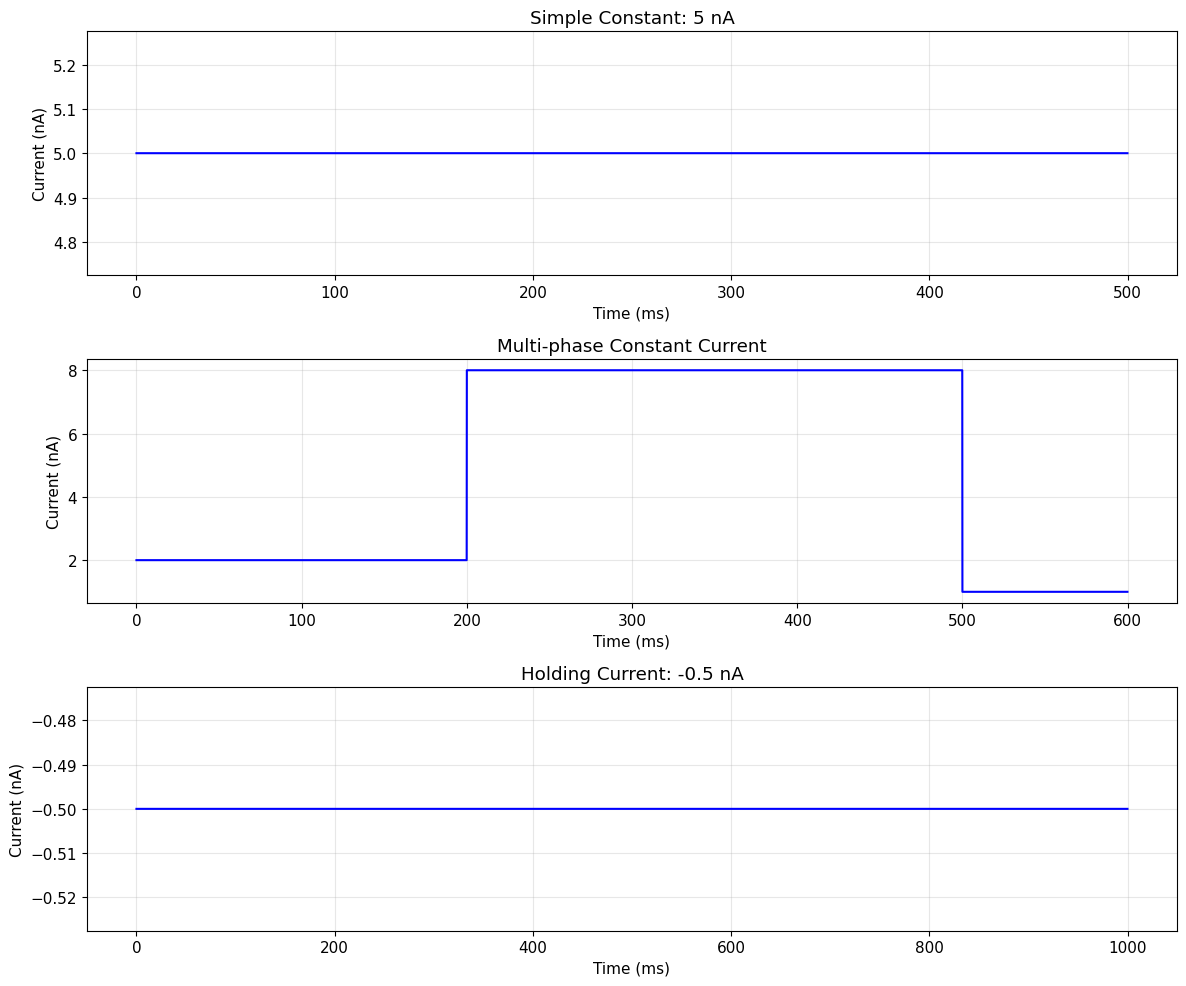

In [38]:
# Simple constant current
const_simple = braintools.input.constant([(5.0, 500 * u.ms)])[0]

# Multi-phase constant current
const_multi = braintools.input.constant([
    (2.0, 200 * u.ms),  # 2 nA for 200 ms
    (8.0, 300 * u.ms),  # 8 nA for 300 ms
    (1.0, 100 * u.ms)  # 1 nA for 100 ms
])[0]

# Holding current for patch clamp
holding = braintools.input.constant([(-0.5, 1000 * u.ms)])[0]  # -0.5 nA holding

# Plot examples
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

plot_signal(const_simple, 500 * u.ms, 'Simple Constant: 5 nA', axes[0])
plot_signal(const_multi, 600 * u.ms, 'Multi-phase Constant Current', axes[1])
plot_signal(holding, 1000 * u.ms, 'Holding Current: -0.5 nA', axes[2])

plt.tight_layout()
plt.show()

### 1.2 Step Functions

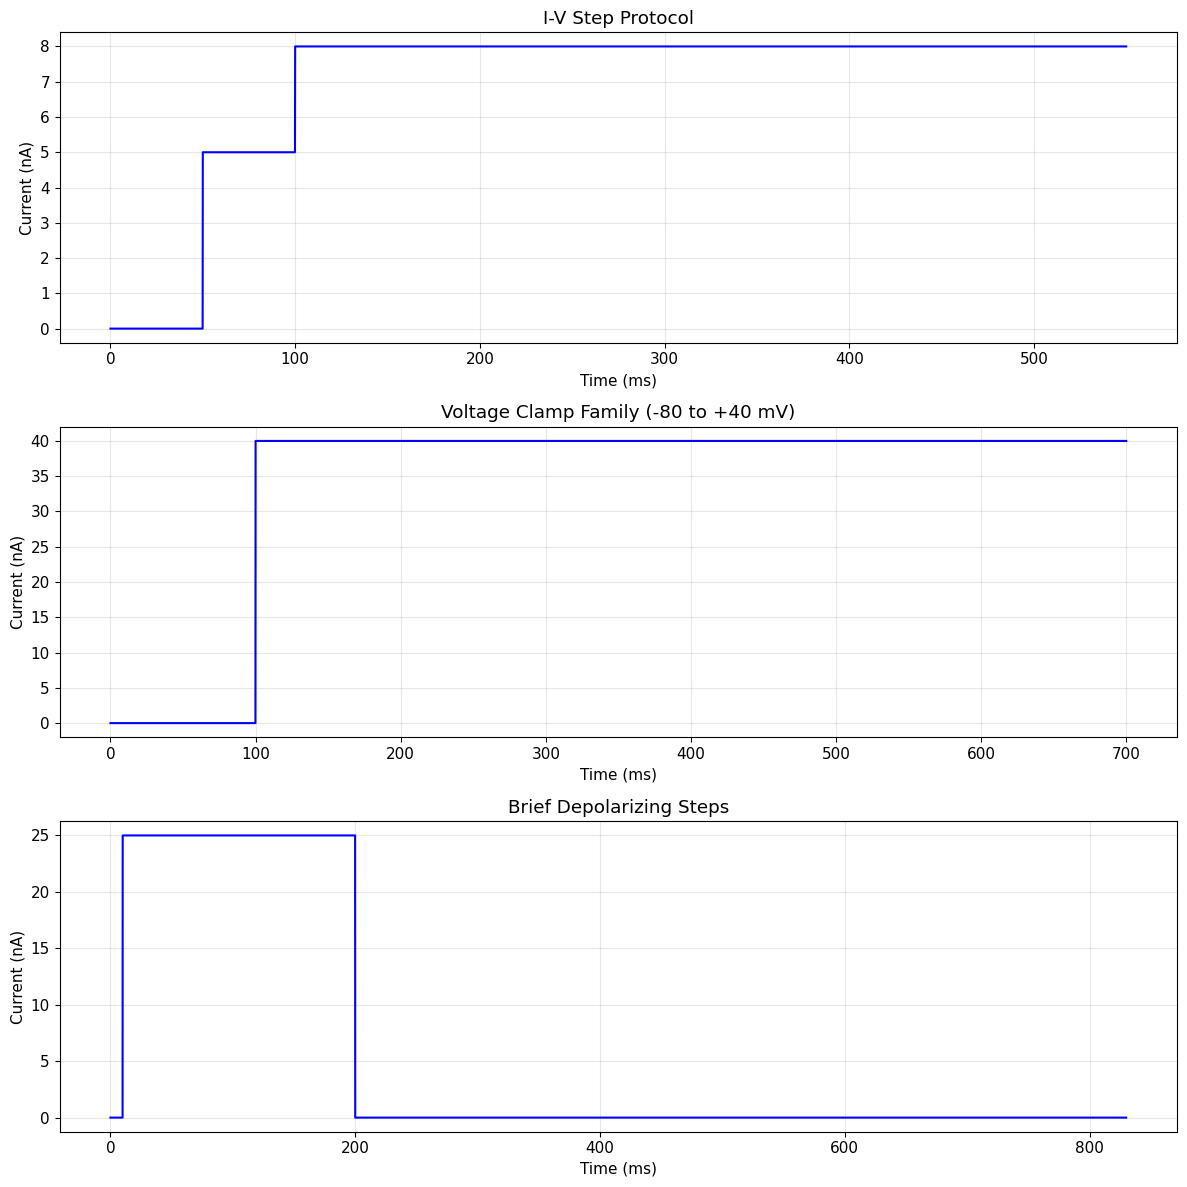

In [39]:
# Classic step protocol for I-V measurements
iv_steps = braintools.input.step(
    [-2, 0, 2, 5, 8, 10, 5, 0],
    [50 * u.ms, 50 * u.ms, 50 * u.ms, 100 * u.ms, 100 * u.ms, 100 * u.ms, 50 * u.ms, 50 * u.ms],
    duration=550 * u.ms
)

# Voltage clamp family (-80 to +40 mV in 10 mV steps)
# Note: these would be voltage values in real voltage clamp
vc_family = braintools.input.step(
    [-80, -60, -40, -20, 0, 20, 40],
    [100 * u.ms] * 7,
    duration=700 * u.ms
)

# Brief depolarizing steps
brief_steps = braintools.input.step(
    [0, 15, 0, 20, 0, 25, 0],
    [200 * u.ms, 10 * u.ms, 200 * u.ms, 10 * u.ms, 200 * u.ms, 10 * u.ms, 200 * u.ms],
    duration=830 * u.ms
)

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

plot_signal(iv_steps, 550 * u.ms, 'I-V Step Protocol', axes[0])
plot_signal(vc_family, 700 * u.ms, 'Voltage Clamp Family (-80 to +40 mV)', axes[1])
plot_signal(brief_steps, 830 * u.ms, 'Brief Depolarizing Steps', axes[2])

plt.tight_layout()
plt.show()

### 1.3 Ramp Currents

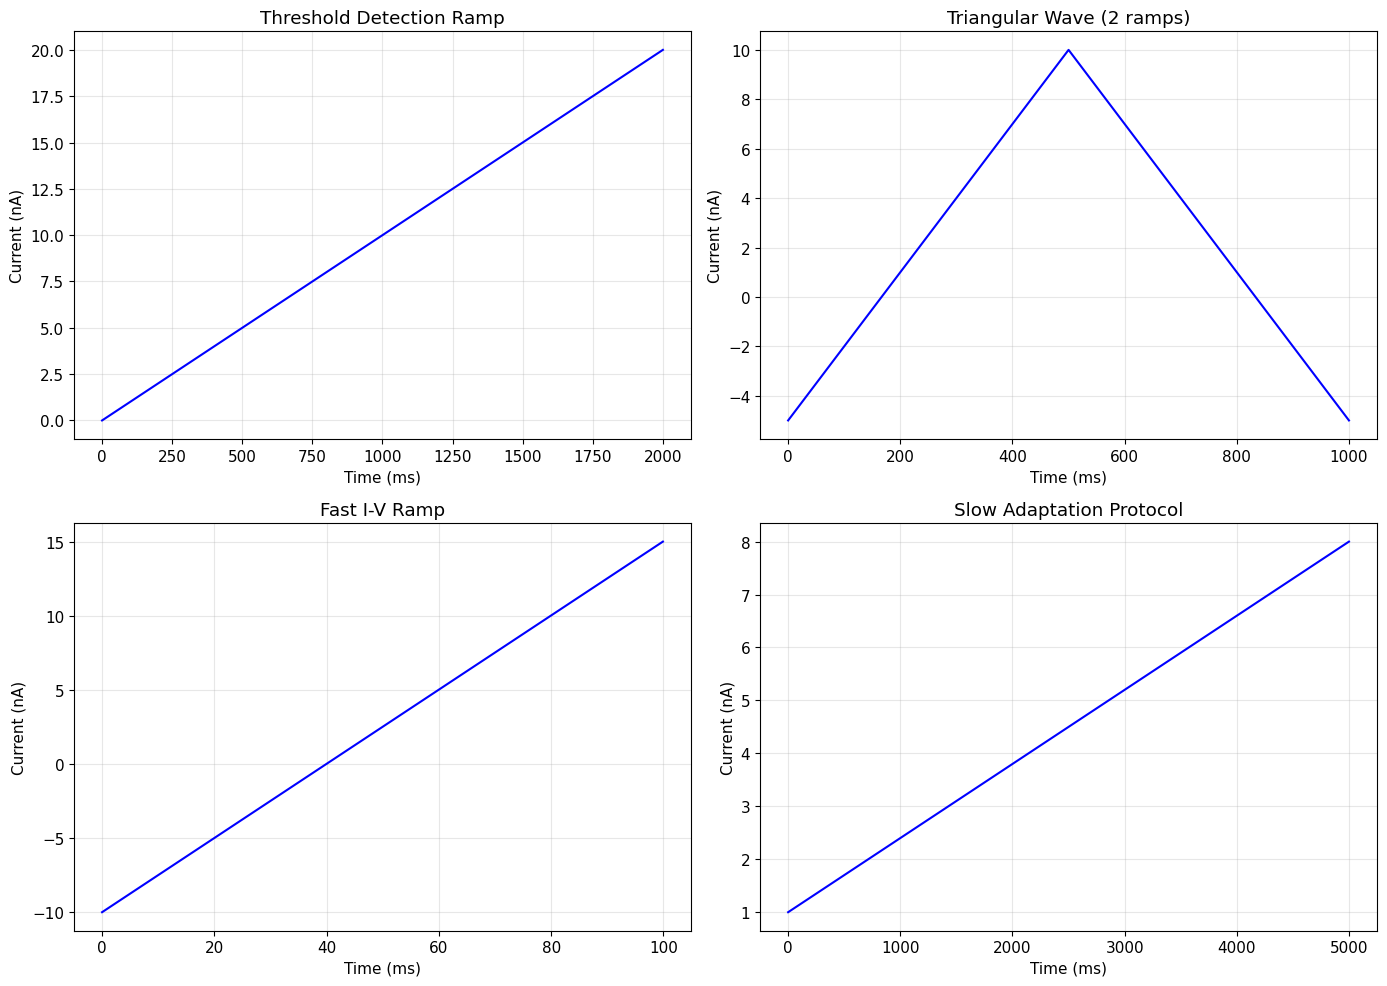

In [40]:
# Linear ramp for threshold detection
threshold_ramp = braintools.input.ramp(0, 20, 2000 * u.ms)

# Triangular wave using two ramps
ramp_up = braintools.input.ramp(-5, 10, 500 * u.ms)
ramp_down = braintools.input.ramp(10, -5, 500 * u.ms)
triangular = np.concatenate([ramp_up, ramp_down])

# Fast ramp for I-V relationships
fast_ramp = braintools.input.ramp(-10, 15, 100 * u.ms)

# Slow adaptation protocol
slow_ramp = braintools.input.ramp(1, 8, 5000 * u.ms)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(threshold_ramp, 2000 * u.ms, 'Threshold Detection Ramp', axes[0])
plot_signal(triangular * u.nA, 1000 * u.ms, 'Triangular Wave (2 ramps)', axes[1])
plot_signal(fast_ramp, 100 * u.ms, 'Fast I-V Ramp', axes[2])
plot_signal(slow_ramp, 5000 * u.ms, 'Slow Adaptation Protocol', axes[3])

plt.tight_layout()
plt.show()

### 1.4 Section-based Protocols

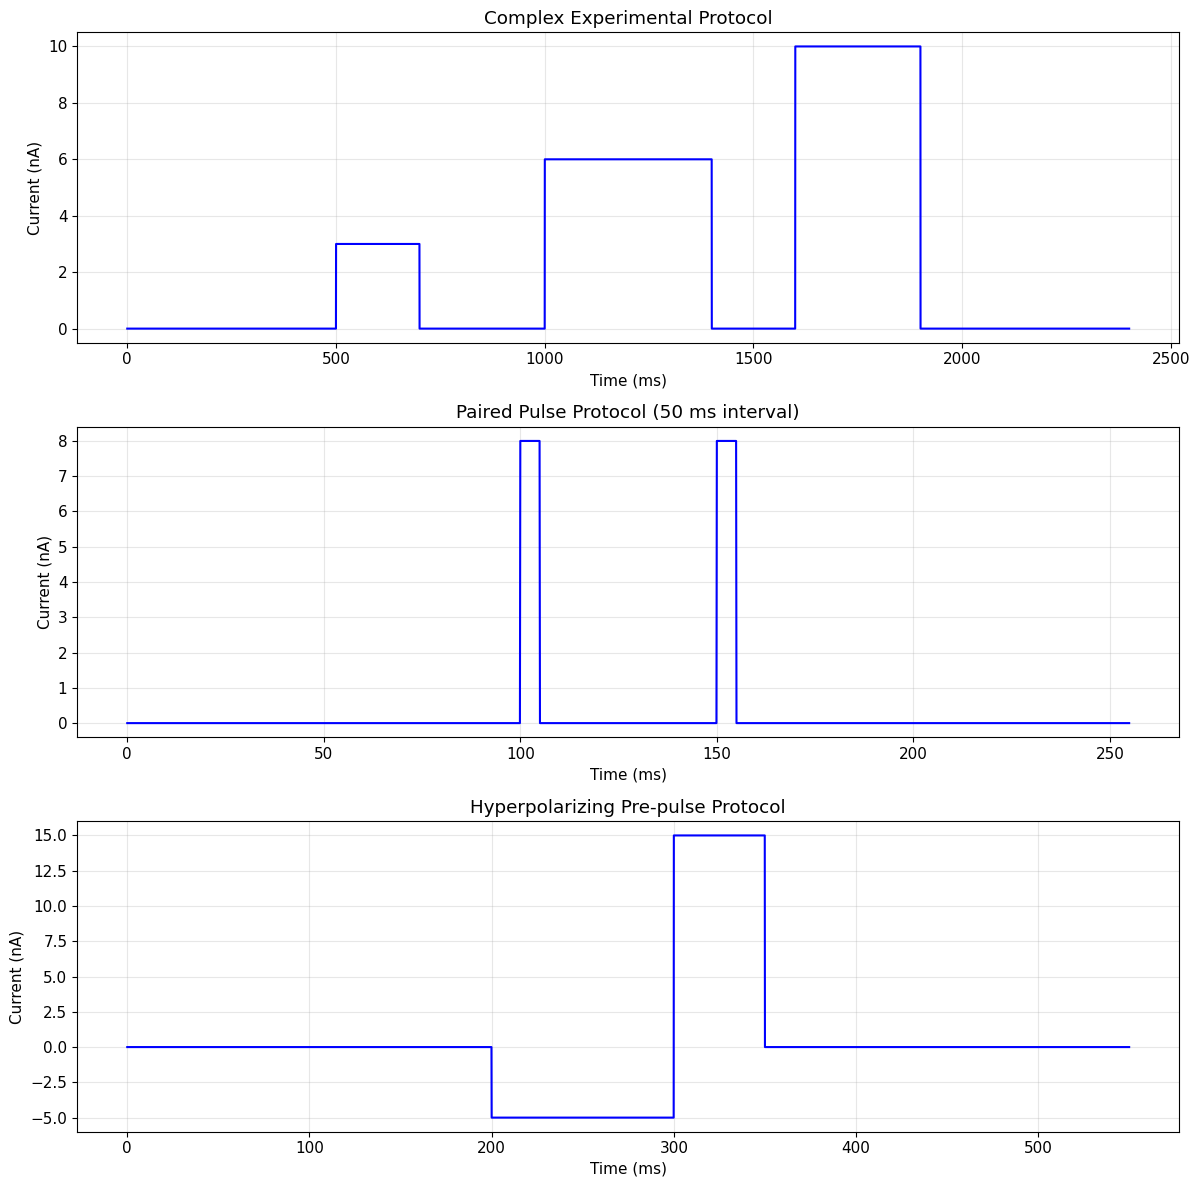

In [41]:
with brainstate.environ.context(dt=dt):
    # Complex experimental protocol
    experiment_protocol = braintools.input.constant([
        (0, 500 * u.ms),  # baseline
        (3, 200 * u.ms),  # small step
        (0, 300 * u.ms),  # return to baseline
        (6, 400 * u.ms),  # medium step
        (0, 200 * u.ms),  # return
        (10, 300 * u.ms),  # large step
        (0, 500 * u.ms)  # recovery
    ])[0]

    # Paired pulse protocol
    paired_pulse = braintools.input.constant([
        (0, 100 * u.ms),  # baseline
        (8, 5 * u.ms),  # first pulse
        (0, 45 * u.ms),  # inter-pulse interval
        (8, 5 * u.ms),  # second pulse
        (0, 100 * u.ms)  # recovery
    ])[0]

    # Hyperpolarizing pre-pulse protocol
    prepulse = braintools.input.constant([
        (0, 200 * u.ms),  # baseline
        (-5, 100 * u.ms),  # hyperpolarizing prepulse
        (15, 50 * u.ms),  # test pulse
        (0, 200 * u.ms)  # recovery
    ])[0]

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

plot_signal(experiment_protocol, 2400 * u.ms, 'Complex Experimental Protocol', axes[0])
plot_signal(paired_pulse, 255 * u.ms, 'Paired Pulse Protocol (50 ms interval)', axes[1])
plot_signal(prepulse, 550 * u.ms, 'Hyperpolarizing Pre-pulse Protocol', axes[2])

plt.tight_layout()
plt.show()

## 2. Waveform Functions

Generate periodic and complex waveforms for rhythmic stimulation.

### 2.1 Sinusoidal Currents

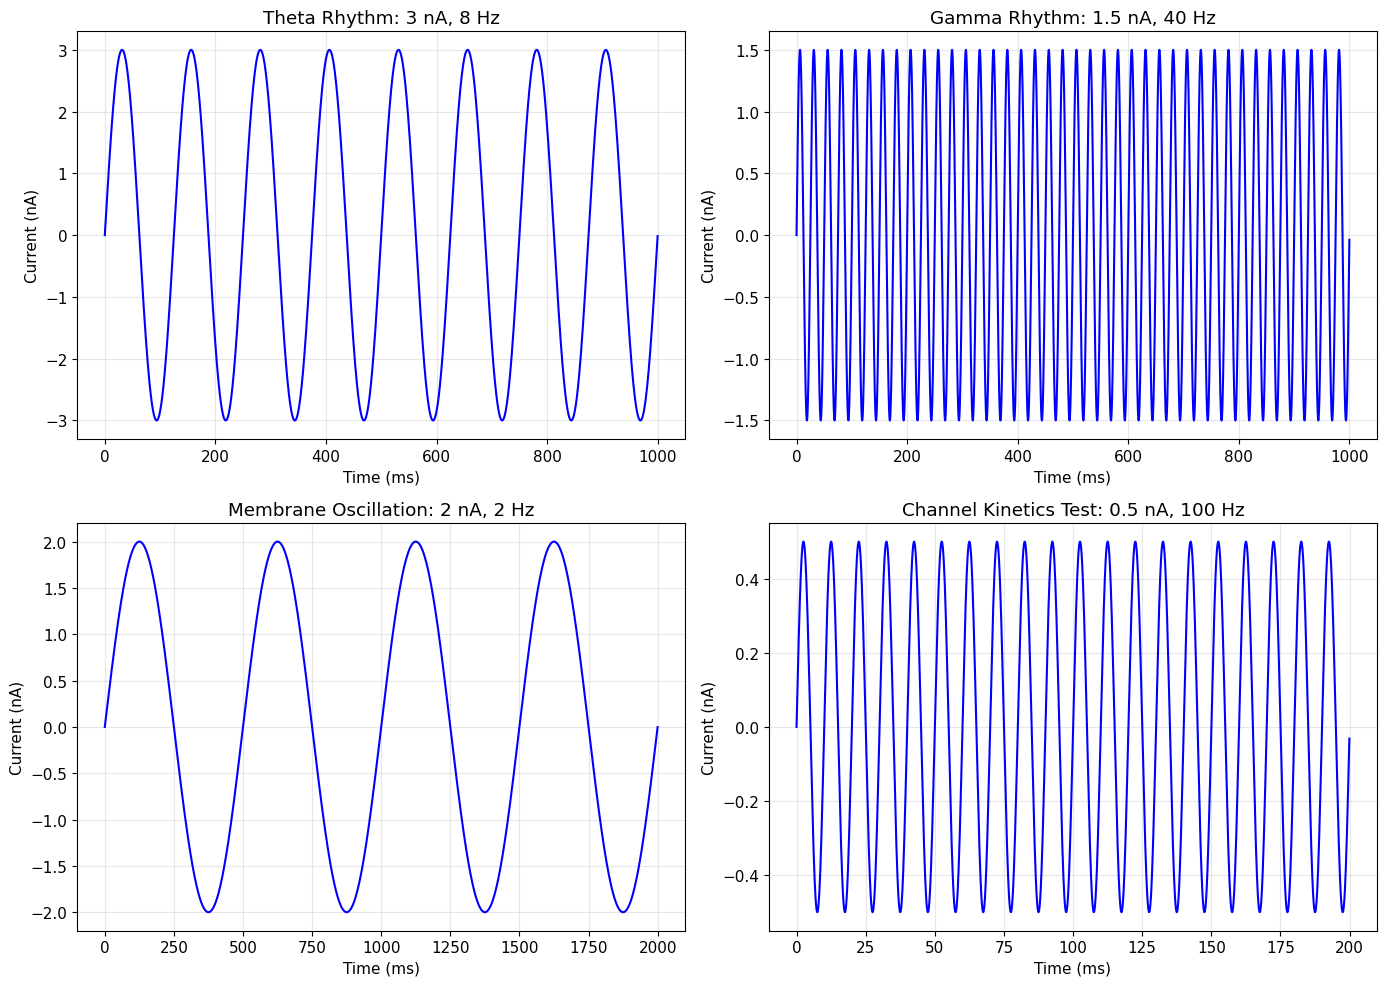

In [42]:
with brainstate.environ.context(dt=dt):
    # Theta rhythm (8 Hz)
    theta = braintools.input.sinusoidal(3.0, 8 * u.Hz, 1000 * u.ms)

    # Gamma rhythm (40 Hz) 
    gamma = braintools.input.sinusoidal(1.5, 40 * u.Hz, 1000 * u.ms)

    # Low frequency for membrane oscillations
    membrane_osc = braintools.input.sinusoidal(2.0, 2 * u.Hz, 2000 * u.ms)

    # High frequency for channel kinetics
    channel_test = braintools.input.sinusoidal(0.5, 100 * u.Hz, 200 * u.ms)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(theta, 1000 * u.ms, 'Theta Rhythm: 3 nA, 8 Hz', axes[0])
plot_signal(gamma, 1000 * u.ms, 'Gamma Rhythm: 1.5 nA, 40 Hz', axes[1])
plot_signal(membrane_osc, 2000 * u.ms, 'Membrane Oscillation: 2 nA, 2 Hz', axes[2])
plot_signal(channel_test, 200 * u.ms, 'Channel Kinetics Test: 0.5 nA, 100 Hz', axes[3])

plt.tight_layout()
plt.show()

### 2.2 Square Waves

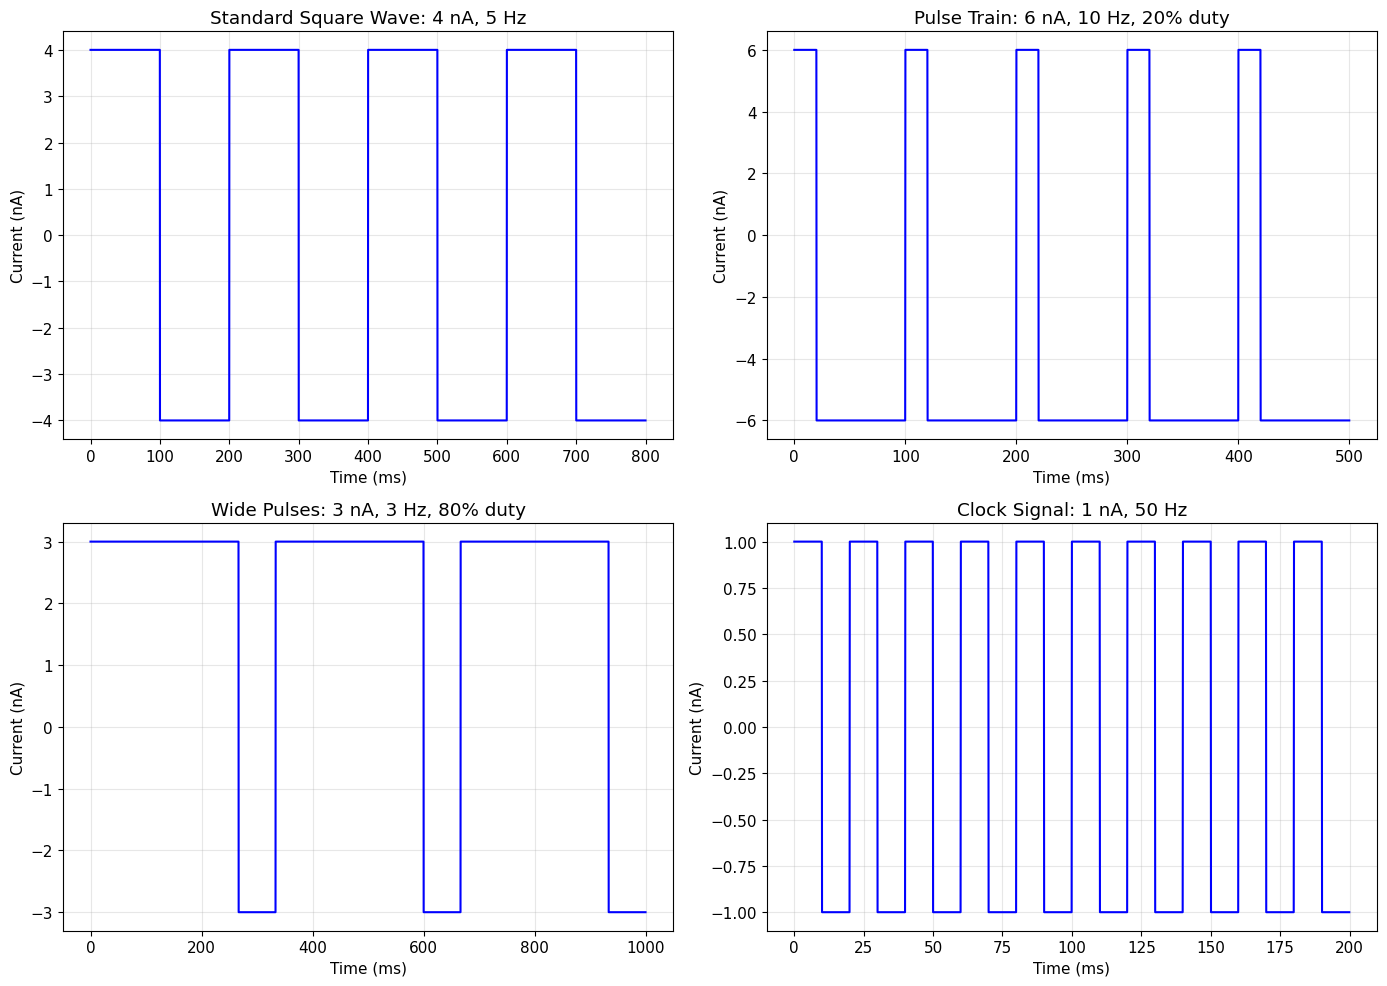

In [43]:
with brainstate.environ.context(dt=dt):
    # Standard square wave (50% duty cycle)
    standard_square = braintools.input.square(4.0, 5 * u.Hz, 800 * u.ms)

    # Pulse train (20% duty cycle) 
    pulse_train = braintools.input.square(6.0, 10 * u.Hz, 500 * u.ms, duty_cycle=0.2)

    # Wide pulses (80% duty cycle)
    wide_pulses = braintools.input.square(3.0, 3 * u.Hz, 1000 * u.ms, duty_cycle=0.8)

    # High frequency clock signal
    clock = braintools.input.square(1.0, 50 * u.Hz, 200 * u.ms, duty_cycle=0.5)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(standard_square, 800 * u.ms, 'Standard Square Wave: 4 nA, 5 Hz', axes[0])
plot_signal(pulse_train, 500 * u.ms, 'Pulse Train: 6 nA, 10 Hz, 20% duty', axes[1])
plot_signal(wide_pulses, 1000 * u.ms, 'Wide Pulses: 3 nA, 3 Hz, 80% duty', axes[2])
plot_signal(clock, 200 * u.ms, 'Clock Signal: 1 nA, 50 Hz', axes[3])

plt.tight_layout()
plt.show()

### 2.3 Triangular and Sawtooth Waves

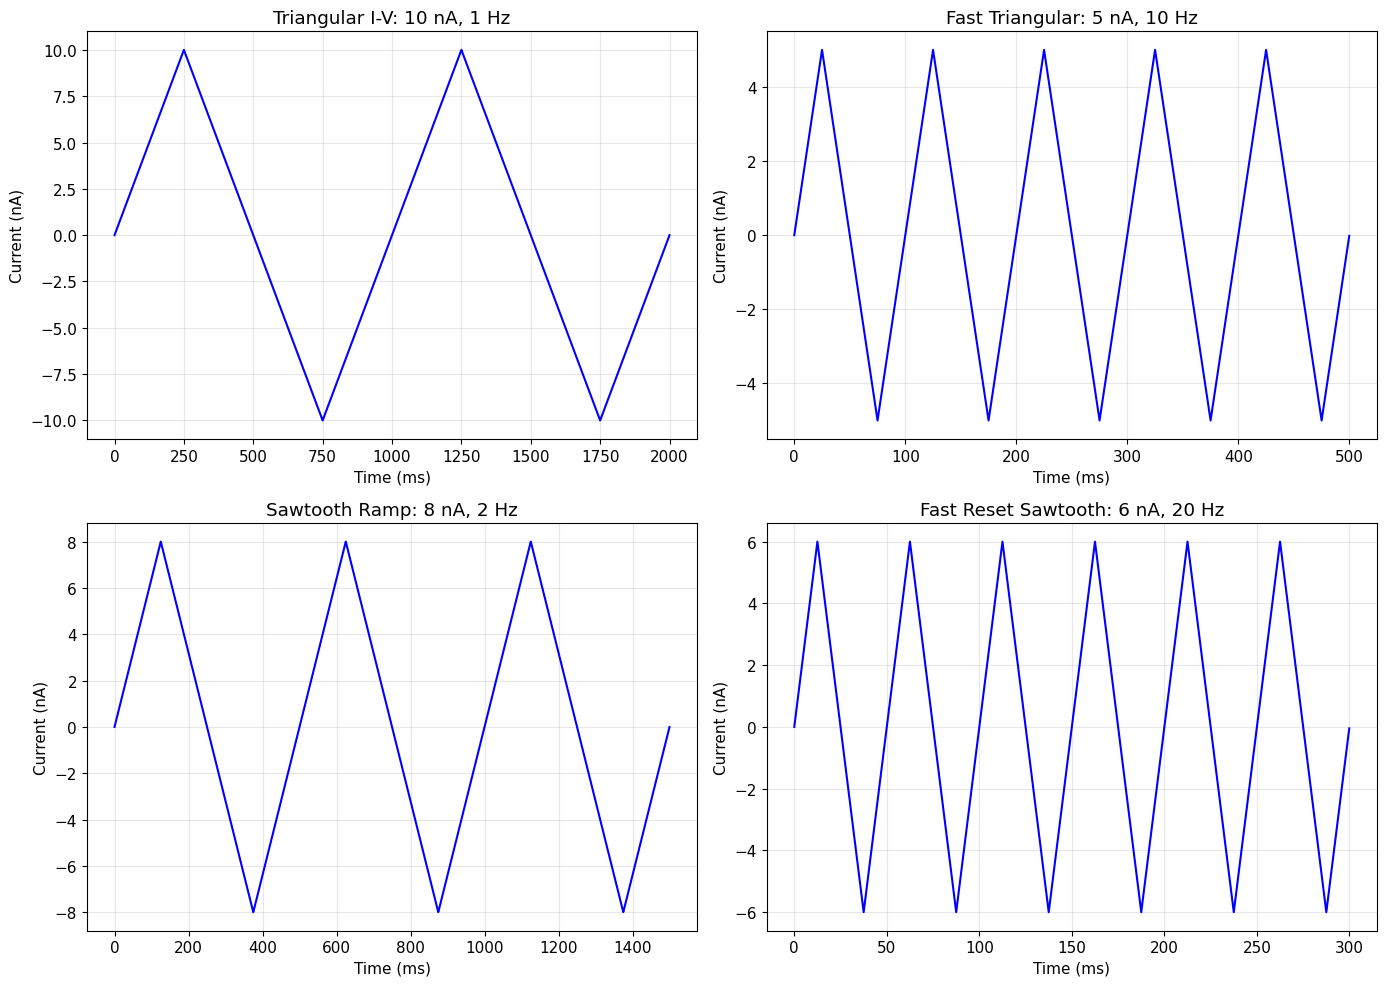

In [44]:
with brainstate.environ.context(dt=dt):
    # Triangular wave for I-V curves
    triangular_iv = braintools.input.triangular(10.0, 1 * u.Hz, 2000 * u.ms)

    # Fast triangular for membrane tests
    fast_triangular = braintools.input.triangular(5.0, 10 * u.Hz, 500 * u.ms)

    # Sawtooth for ramp protocols
    sawtooth_ramp = braintools.input.triangular(8.0, 2 * u.Hz, 1500 * u.ms)

    # Fast reset sawtooth
    fast_sawtooth = braintools.input.triangular(6.0, 20 * u.Hz, 300 * u.ms)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(triangular_iv, 2000 * u.ms, 'Triangular I-V: 10 nA, 1 Hz', axes[0])
plot_signal(fast_triangular, 500 * u.ms, 'Fast Triangular: 5 nA, 10 Hz', axes[1])
plot_signal(sawtooth_ramp, 1500 * u.ms, 'Sawtooth Ramp: 8 nA, 2 Hz', axes[2])
plot_signal(fast_sawtooth, 300 * u.ms, 'Fast Reset Sawtooth: 6 nA, 20 Hz', axes[3])

plt.tight_layout()
plt.show()

### 2.4 Chirp Signals (Frequency Sweeps)

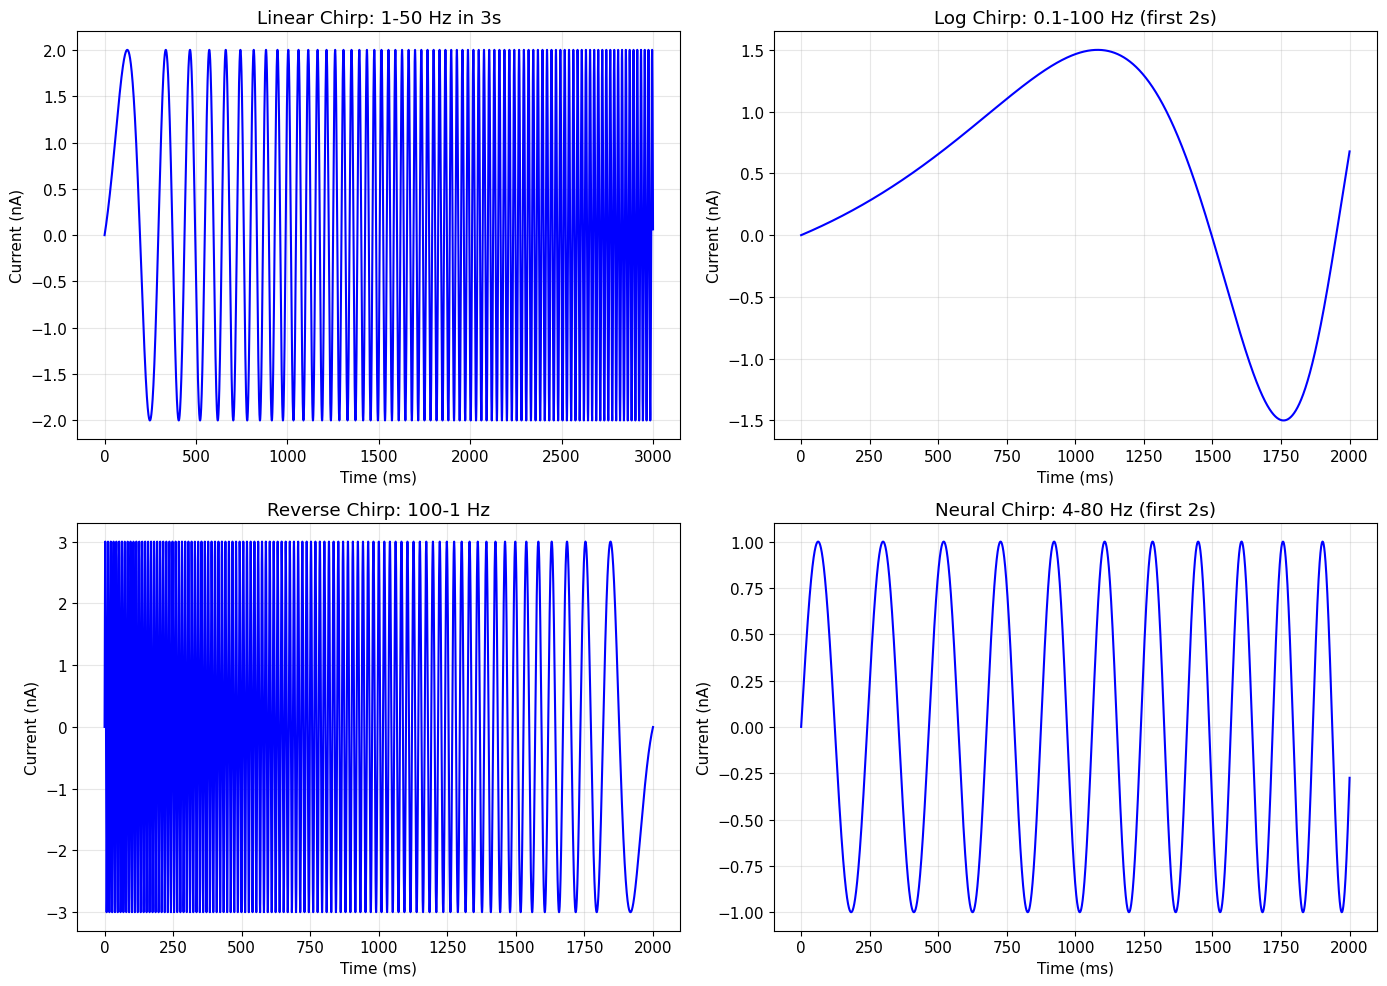

In [45]:
with brainstate.environ.context(dt=dt):
    # Linear chirp for impedance measurements
    linear_chirp = braintools.input.chirp(2.0, 1 * u.Hz, 50 * u.Hz, 3000 * u.ms, method='linear')

    # Logarithmic chirp for resonance detection
    log_chirp = braintools.input.chirp(1.5, 0.1 * u.Hz, 100 * u.Hz, 5000 * u.ms, method='logarithmic')

    # Reverse chirp (high to low frequency)
    reverse_chirp = braintools.input.chirp(3.0, 100 * u.Hz, 1 * u.Hz, 2000 * u.ms)

    # Theta-gamma chirp for neural oscillations
    neural_chirp = braintools.input.chirp(1.0, 4 * u.Hz, 80 * u.Hz, 10000 * u.ms, method='logarithmic')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(linear_chirp, 3000 * u.ms, 'Linear Chirp: 1-50 Hz in 3s', axes[0])
# Show only first 2 seconds of log chirp
plot_signal(log_chirp[:20000], 2000 * u.ms, 'Log Chirp: 0.1-100 Hz (first 2s)', axes[1])
plot_signal(reverse_chirp, 2000 * u.ms, 'Reverse Chirp: 100-1 Hz', axes[2])
# Show only first 2 seconds of neural chirp
plot_signal(neural_chirp[:20000], 2000 * u.ms, 'Neural Chirp: 4-80 Hz (first 2s)', axes[3])

plt.tight_layout()
plt.show()

## 3. Pulse Functions

Generate realistic synaptic-like pulses and bursts.

### 3.1 Spike Trains

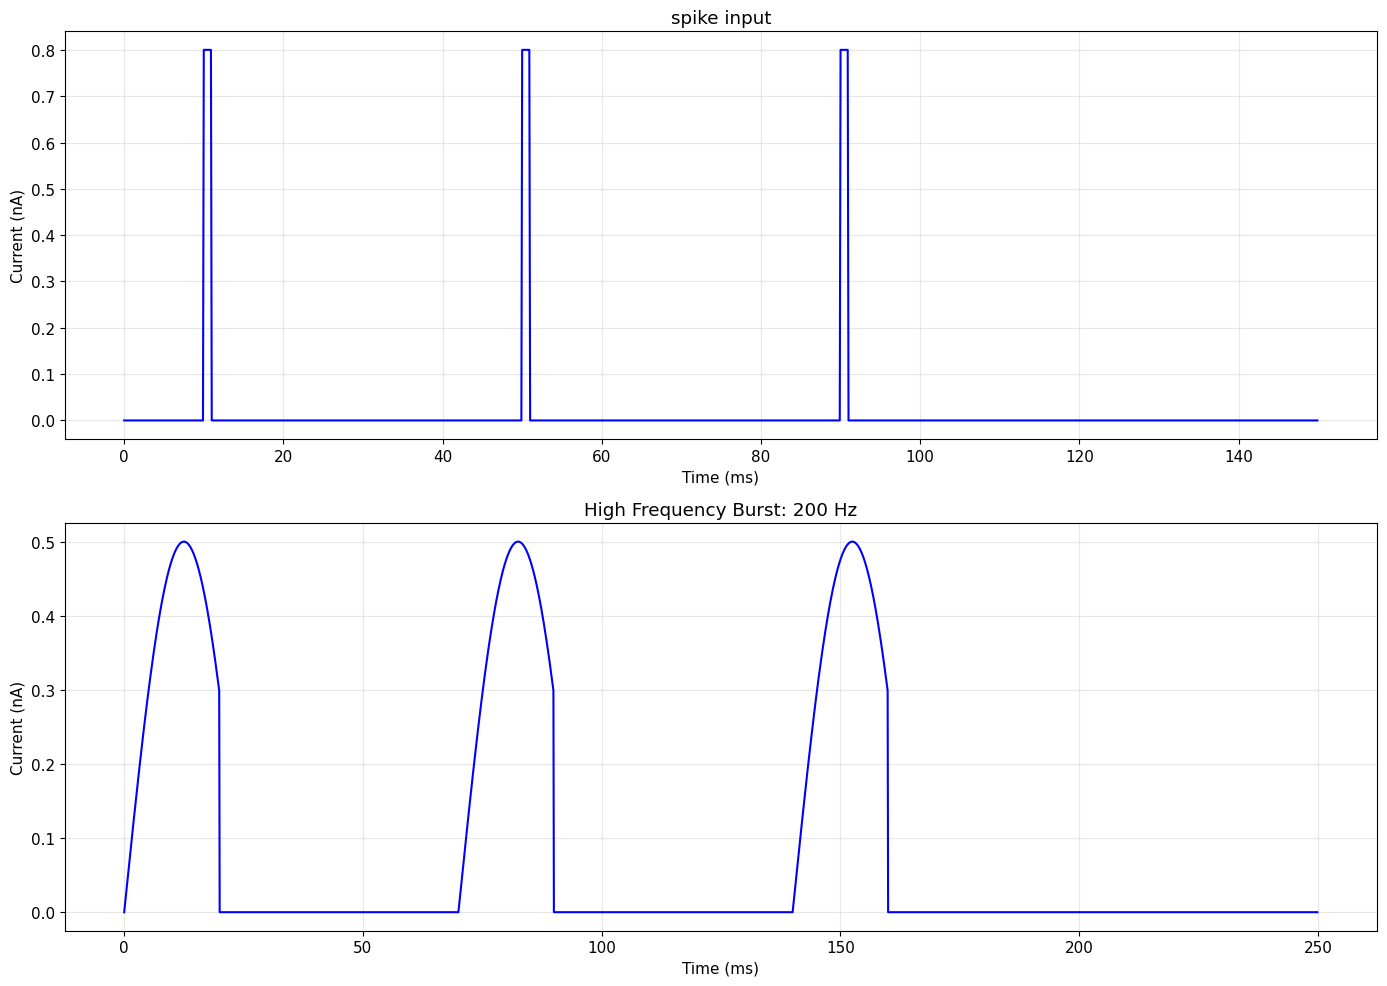

In [46]:
with brainstate.environ.context(dt=dt):
    spikes = braintools.input.spike(
        sp_times=[10, 50, 90] * u.ms,
        sp_lens=1 * u.ms,
        sp_sizes=0.8 * u.nA,
        duration=150 * u.ms,
    )
    burst = braintools.input.burst(
        burst_amp=0.5 * u.nA,
        burst_freq=20 * u.Hz,
        burst_duration=20 * u.ms,
        inter_burst_interval=50 * u.ms,
        n_bursts=3,
        duration=250 * u.ms,
    )

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
axes = axes.flatten()

plot_signal(spikes, 150 * u.ms, 'spike input', axes[0])
plot_signal(burst, 250 * u.ms, 'High Frequency Burst: 200 Hz', axes[1])

plt.tight_layout()
plt.show()

### 3.2 Gaussian Pulses

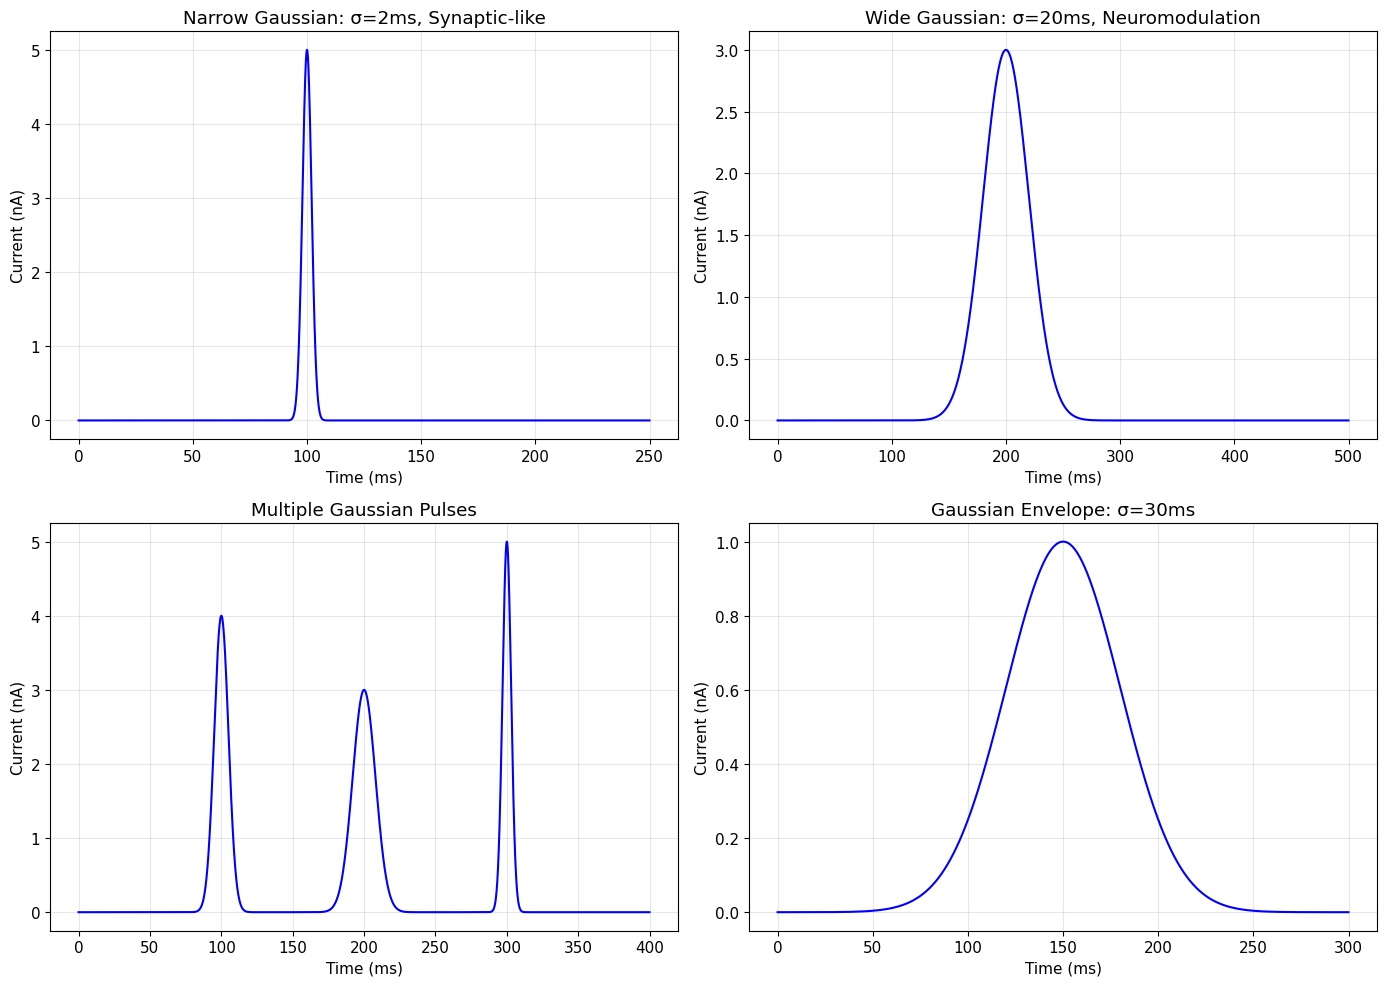

In [47]:
with brainstate.environ.context(dt=dt):
    # Narrow Gaussian pulse (synaptic-like)
    narrow_pulse = braintools.input.gaussian_pulse(5.0, 100 * u.ms, 2 * u.ms, 250 * u.ms)

    # Wide Gaussian pulse (neuromodulation-like)
    wide_pulse = braintools.input.gaussian_pulse(3.0, 200 * u.ms, 20 * u.ms, 500 * u.ms)

    # Multiple Gaussian pulses
    multi_gaussian = (
        braintools.input.gaussian_pulse(4.0, 100 * u.ms, 5 * u.ms, 400 * u.ms) +
        braintools.input.gaussian_pulse(3.0, 200 * u.ms, 8 * u.ms, 400 * u.ms) +
        braintools.input.gaussian_pulse(5.0, 300 * u.ms, 3 * u.ms, 400 * u.ms)
    )

    # Gaussian envelope for burst
    envelope = braintools.input.gaussian_pulse(1.0, 150 * u.ms, 30 * u.ms, 300 * u.ms)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(narrow_pulse, 250 * u.ms, 'Narrow Gaussian: σ=2ms, Synaptic-like', axes[0])
plot_signal(wide_pulse, 500 * u.ms, 'Wide Gaussian: σ=20ms, Neuromodulation', axes[1])
plot_signal(multi_gaussian, 400 * u.ms, 'Multiple Gaussian Pulses', axes[2])
plot_signal(envelope, 300 * u.ms, 'Gaussian Envelope: σ=30ms', axes[3])

plt.tight_layout()
plt.show()

### 3.3 Exponential Pulses

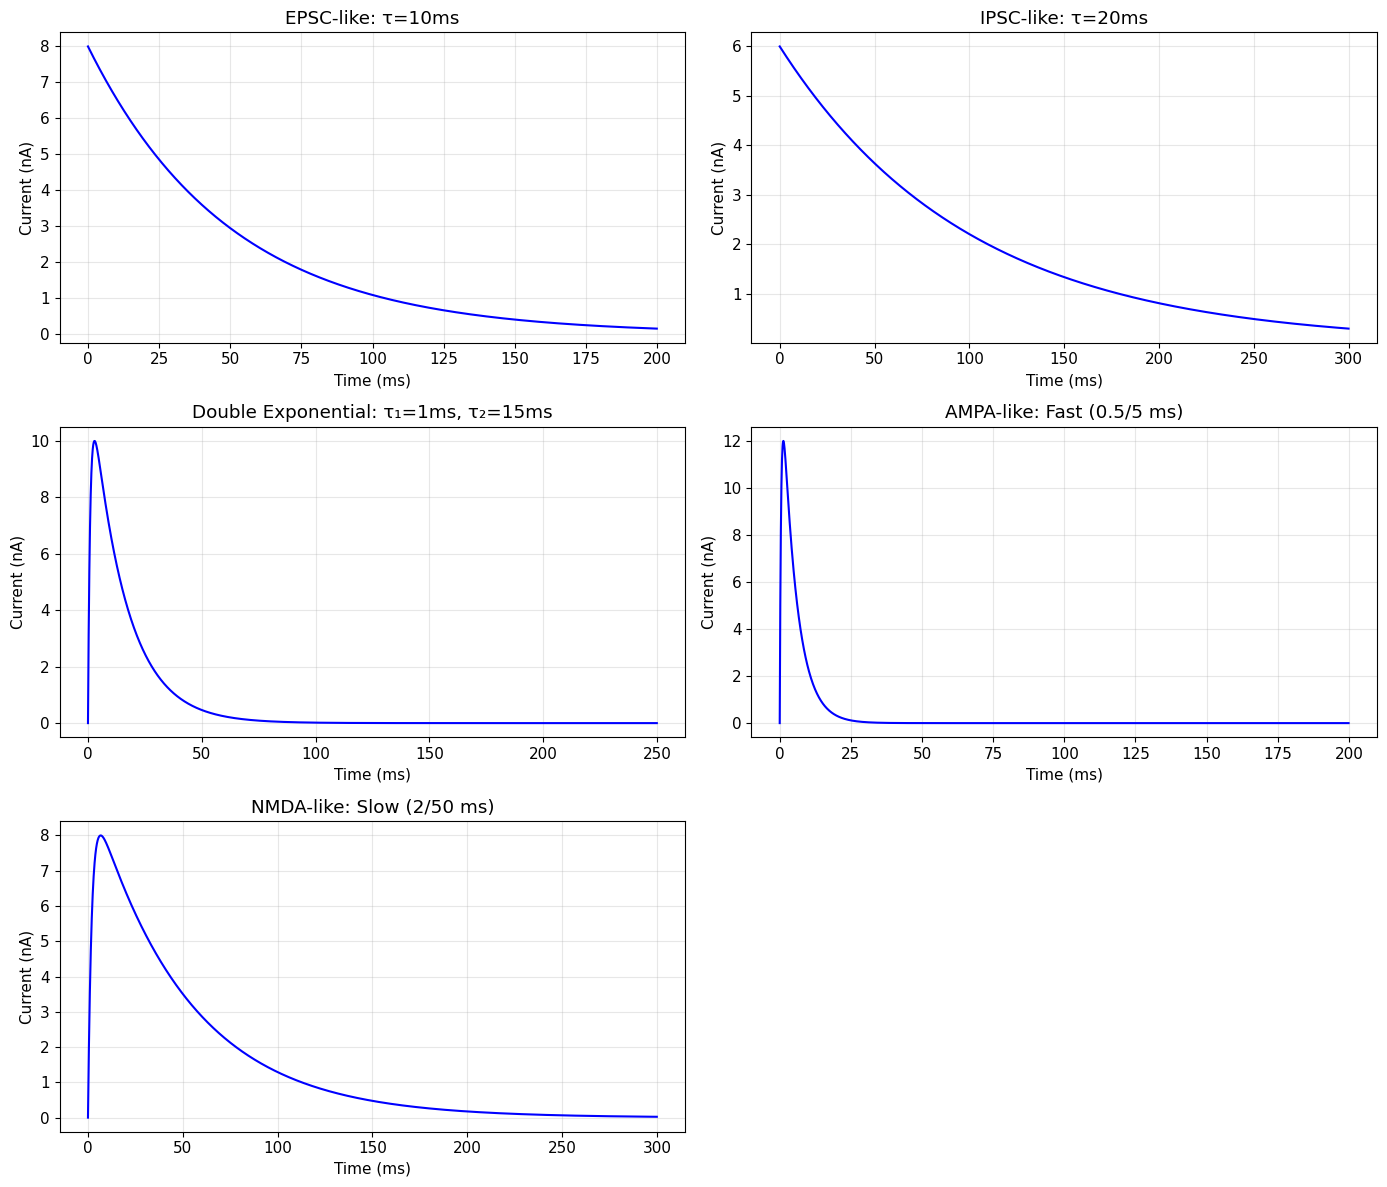

In [48]:
with brainstate.environ.context(dt=dt):
    # EPSC-like single exponential
    epsc = braintools.input.exponential_decay(8.0, 50 * u.ms, 200 * u.ms)

    # IPSC-like single exponential (longer decay)
    ipsc = braintools.input.exponential_decay(6.0, 100 * u.ms, 300 * u.ms)

    # Double exponential (realistic synapse)
    double_exp = braintools.input.double_exponential(10.0, 1 * u.ms, 15 * u.ms, 250 * u.ms)

    # Fast AMPA-like response
    ampa_like = braintools.input.double_exponential(12.0, 0.5 * u.ms, 5 * u.ms, 200 * u.ms)

    # Slow NMDA-like response  
    nmda_like = braintools.input.double_exponential(8.0, 2 * u.ms, 50 * u.ms, 300 * u.ms)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

plot_signal(epsc, 200 * u.ms, 'EPSC-like: τ=10ms', axes[0])
plot_signal(ipsc, 300 * u.ms, 'IPSC-like: τ=20ms', axes[1])
plot_signal(double_exp, 250 * u.ms, 'Double Exponential: τ₁=1ms, τ₂=15ms', axes[2])
plot_signal(ampa_like, 200 * u.ms, 'AMPA-like: Fast (0.5/5 ms)', axes[3])
plot_signal(nmda_like, 300 * u.ms, 'NMDA-like: Slow (2/50 ms)', axes[4])

# Leave last subplot empty
axes[5].axis('off')

plt.tight_layout()
plt.show()

## 4. Stochastic Processes

Generate realistic noise and random processes for neural modeling.

### 4.1 Wiener Processes (Brownian Motion)

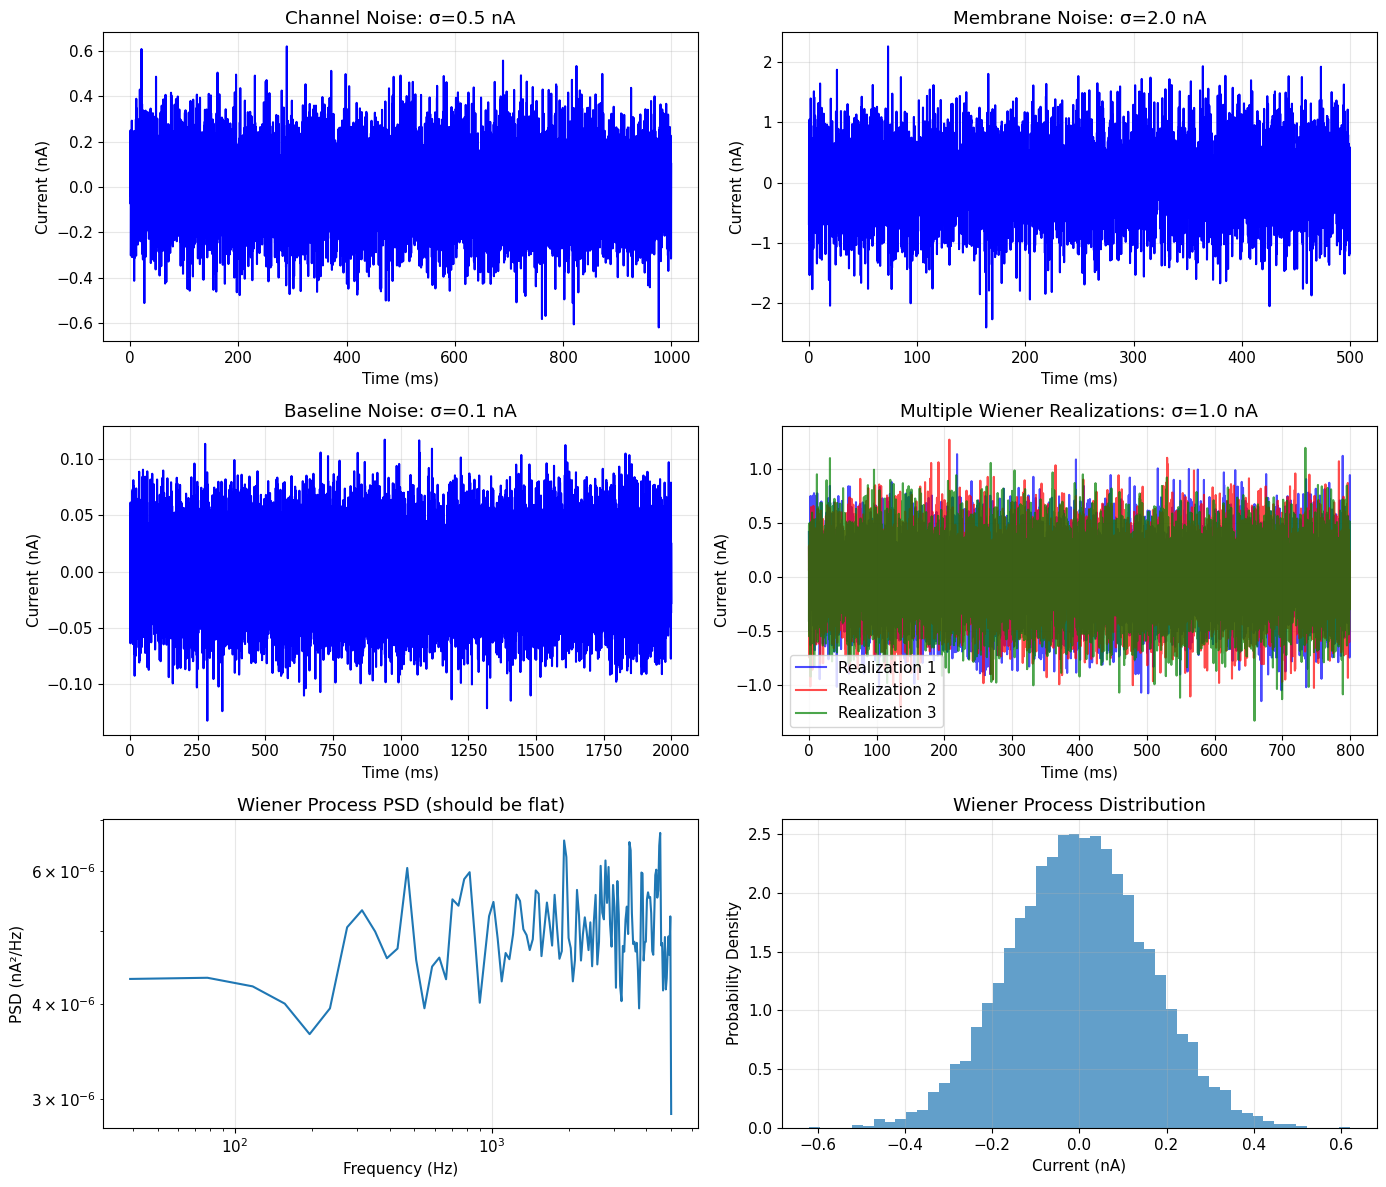

In [49]:
with brainstate.environ.context(dt=dt):
    # Standard Wiener process for channel noise
    channel_noise = braintools.input.wiener_process(sigma=0.5, duration=1000 * u.ms, seed=42)

    # Strong Wiener process for membrane fluctuations
    membrane_noise = braintools.input.wiener_process(sigma=2.0, duration=500 * u.ms, seed=123)

    # Weak Wiener process for baseline fluctuations
    baseline_noise = braintools.input.wiener_process(sigma=0.1, duration=2000 * u.ms, seed=456)

    # Multiple realizations for comparison
    wiener_1 = braintools.input.wiener_process(sigma=1.0, duration=800 * u.ms, seed=10)
    wiener_2 = braintools.input.wiener_process(sigma=1.0, duration=800 * u.ms, seed=20)
    wiener_3 = braintools.input.wiener_process(sigma=1.0, duration=800 * u.ms, seed=30)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

plot_signal(channel_noise, 1000 * u.ms, 'Channel Noise: σ=0.5 nA', axes[0, 0])
plot_signal(membrane_noise, 500 * u.ms, 'Membrane Noise: σ=2.0 nA', axes[0, 1])
plot_signal(baseline_noise, 2000 * u.ms, 'Baseline Noise: σ=0.1 nA', axes[1, 0])

# Plot multiple realizations on same axes
ax = axes[1, 1]
dt_val = u.get_magnitude(dt)
time_points = np.arange(0, 800, dt_val)
ax.plot(time_points, u.get_magnitude(wiener_1), 'b-', alpha=0.7, label='Realization 1')
ax.plot(time_points, u.get_magnitude(wiener_2), 'r-', alpha=0.7, label='Realization 2')
ax.plot(time_points, u.get_magnitude(wiener_3), 'g-', alpha=0.7, label='Realization 3')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.set_title('Multiple Wiener Realizations: σ=1.0 nA')
ax.legend()
ax.grid(True, alpha=0.3)

# Statistics analysis
ax = axes[2, 0]
# Power spectral density
f, psd = scipy_signal.welch(u.get_magnitude(channel_noise), fs=1000 / u.get_magnitude(dt))
ax.loglog(f[1:], psd[1:])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (nA²/Hz)')
ax.set_title('Wiener Process PSD (should be flat)')
ax.grid(True, alpha=0.3)

# Histogram
ax = axes[2, 1]
ax.hist(u.get_magnitude(channel_noise), bins=50, density=True, alpha=0.7)
ax.set_xlabel('Current (nA)')
ax.set_ylabel('Probability Density')
ax.set_title('Wiener Process Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Ornstein-Uhlenbeck Processes (Colored Noise)

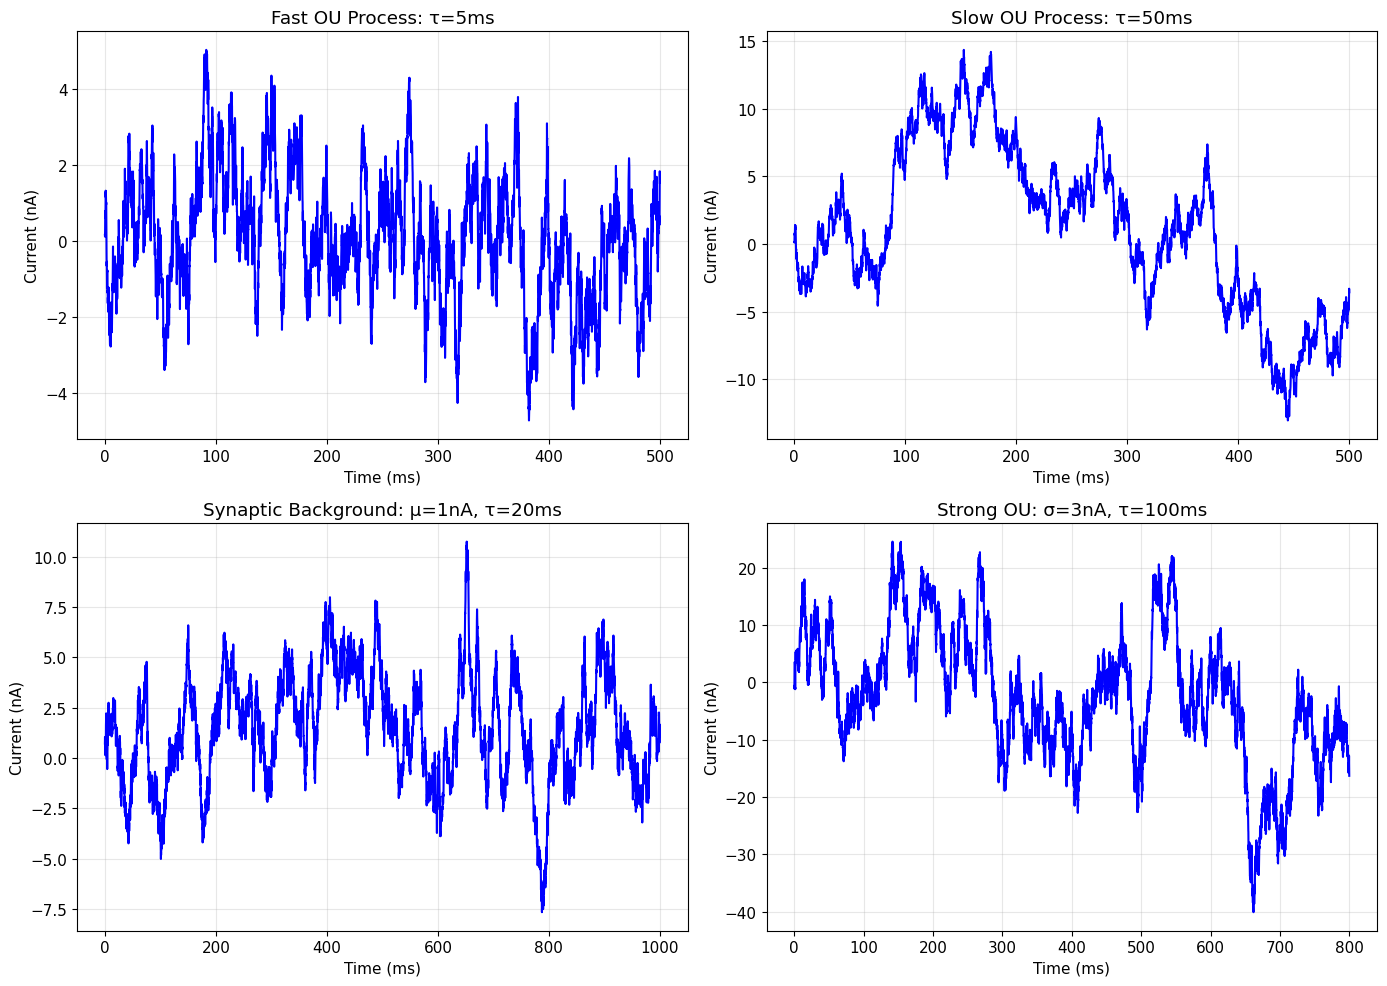

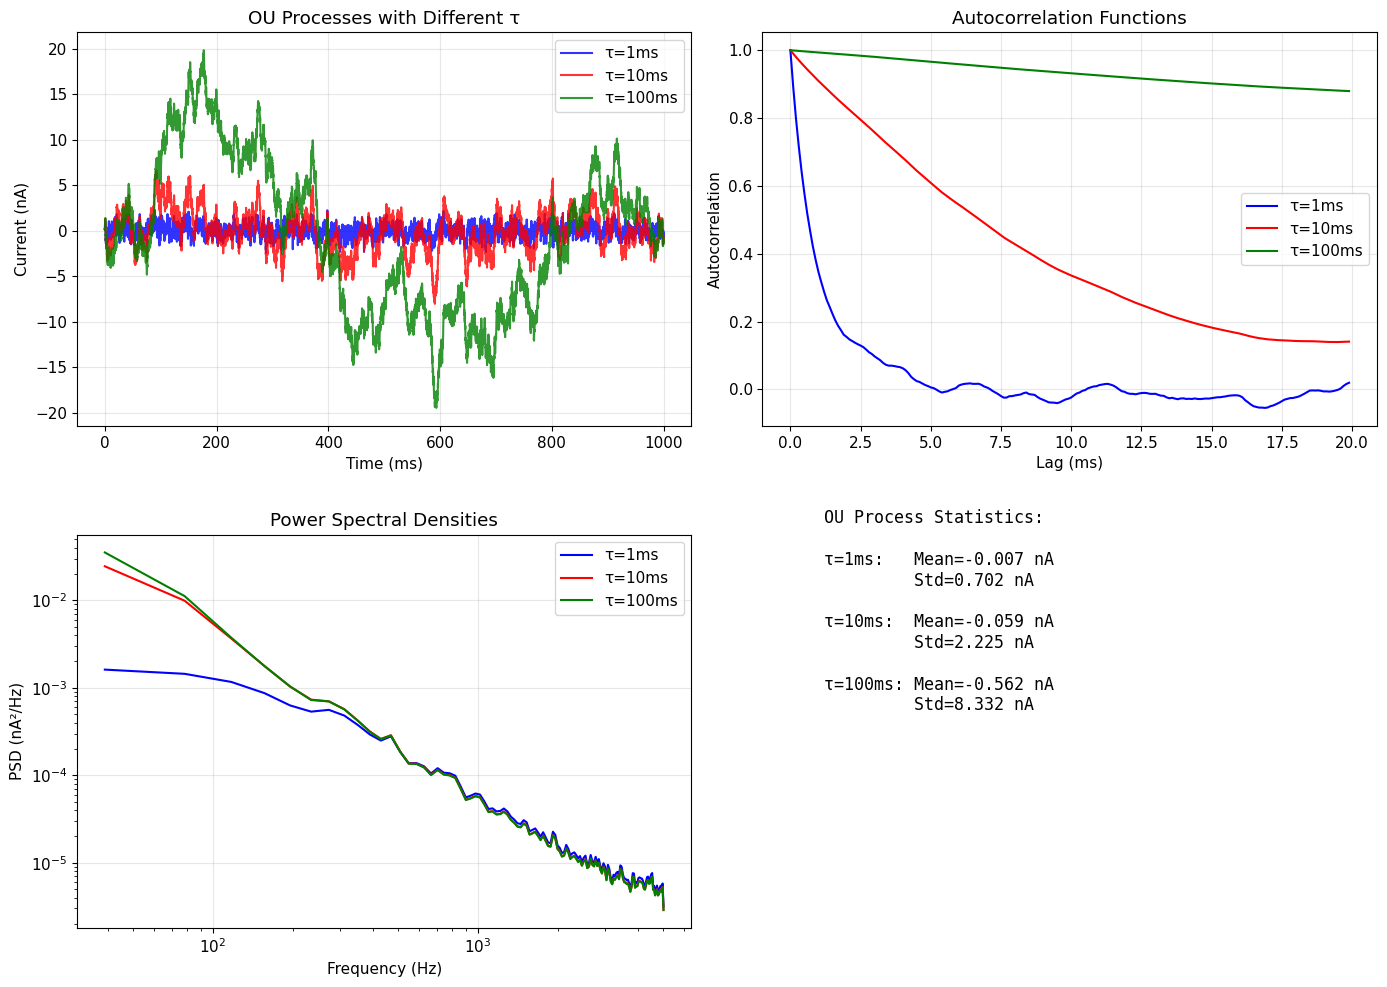

In [50]:
with brainstate.environ.context(dt=dt):
    # Fast OU process (short correlation time)
    fast_ou = braintools.input.ou_process(0., sigma=1.0, tau=5 * u.ms, duration=500 * u.ms, seed=42)

    # Slow OU process (long correlation time)
    slow_ou = braintools.input.ou_process(0., sigma=1.0, tau=50 * u.ms, duration=500 * u.ms, seed=42)

    # Synaptic background activity
    synaptic_bg = braintools.input.ou_process(1., sigma=0.8, tau=20 * u.ms, duration=1000 * u.ms, seed=123)

    # Strong correlated noise
    strong_ou = braintools.input.ou_process(0., sigma=3.0, tau=100 * u.ms, duration=800 * u.ms, seed=456)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(fast_ou, 500 * u.ms, 'Fast OU Process: τ=5ms', axes[0])
plot_signal(slow_ou, 500 * u.ms, 'Slow OU Process: τ=50ms', axes[1])
plot_signal(synaptic_bg, 1000 * u.ms, 'Synaptic Background: μ=1nA, τ=20ms', axes[2])
plot_signal(strong_ou, 800 * u.ms, 'Strong OU: σ=3nA, τ=100ms', axes[3])

plt.tight_layout()
plt.show()

# Compare OU processes with different correlation times
duration = 1000 * u.ms
ou_1ms = braintools.input.ou_process(0., sigma=1.0, tau=1 * u.ms, duration=duration, seed=42)
ou_10ms = braintools.input.ou_process(0., sigma=1.0, tau=10 * u.ms, duration=duration, seed=42)
ou_100ms = braintools.input.ou_process(0., sigma=1.0, tau=100 * u.ms, duration=duration, seed=42)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series comparison
dt_val = u.get_magnitude(dt)
time_points = np.arange(0, 1000, dt_val)
ax = axes[0, 0]
ax.plot(time_points, u.get_magnitude(ou_1ms), 'b-', alpha=0.8, label='τ=1ms')
ax.plot(time_points, u.get_magnitude(ou_10ms), 'r-', alpha=0.8, label='τ=10ms')
ax.plot(time_points, u.get_magnitude(ou_100ms), 'g-', alpha=0.8, label='τ=100ms')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.set_title('OU Processes with Different τ')
ax.legend()
ax.grid(True, alpha=0.3)

# Autocorrelation comparison
from scipy.signal import correlate


def autocorr(x):
    x = x - np.mean(x)
    autocorr = correlate(x, x, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    return autocorr / autocorr[0]


ax = axes[0, 1]
lags = np.arange(0, 200) * dt_val  # First 200 points
ax.plot(lags, autocorr(u.get_magnitude(ou_1ms))[:200], 'b-', label='τ=1ms')
ax.plot(lags, autocorr(u.get_magnitude(ou_10ms))[:200], 'r-', label='τ=10ms')
ax.plot(lags, autocorr(u.get_magnitude(ou_100ms))[:200], 'g-', label='τ=100ms')
ax.set_xlabel('Lag (ms)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation Functions')
ax.legend()
ax.grid(True, alpha=0.3)

# Power spectral densities
ax = axes[1, 0]
fs = 1000 / dt_val
f1, psd1 = scipy_signal.welch(u.get_magnitude(ou_1ms), fs=fs)
f2, psd2 = scipy_signal.welch(u.get_magnitude(ou_10ms), fs=fs)
f3, psd3 = scipy_signal.welch(u.get_magnitude(ou_100ms), fs=fs)

ax.loglog(f1[1:], psd1[1:], 'b-', label='τ=1ms')
ax.loglog(f2[1:], psd2[1:], 'r-', label='τ=10ms')
ax.loglog(f3[1:], psd3[1:], 'g-', label='τ=100ms')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (nA²/Hz)')
ax.set_title('Power Spectral Densities')
ax.legend()
ax.grid(True, alpha=0.3)

# Statistics
axes[1, 1].axis('off')
stats_text = f"""OU Process Statistics:

τ=1ms:   Mean={np.mean(u.get_magnitude(ou_1ms)):.3f} nA
         Std={np.std(u.get_magnitude(ou_1ms)):.3f} nA

τ=10ms:  Mean={np.mean(u.get_magnitude(ou_10ms)):.3f} nA
         Std={np.std(u.get_magnitude(ou_10ms)):.3f} nA

τ=100ms: Mean={np.mean(u.get_magnitude(ou_100ms)):.3f} nA
         Std={np.std(u.get_magnitude(ou_100ms)):.3f} nA
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace')

plt.tight_layout()
plt.show()

### 4.3 Poisson Spike Trains

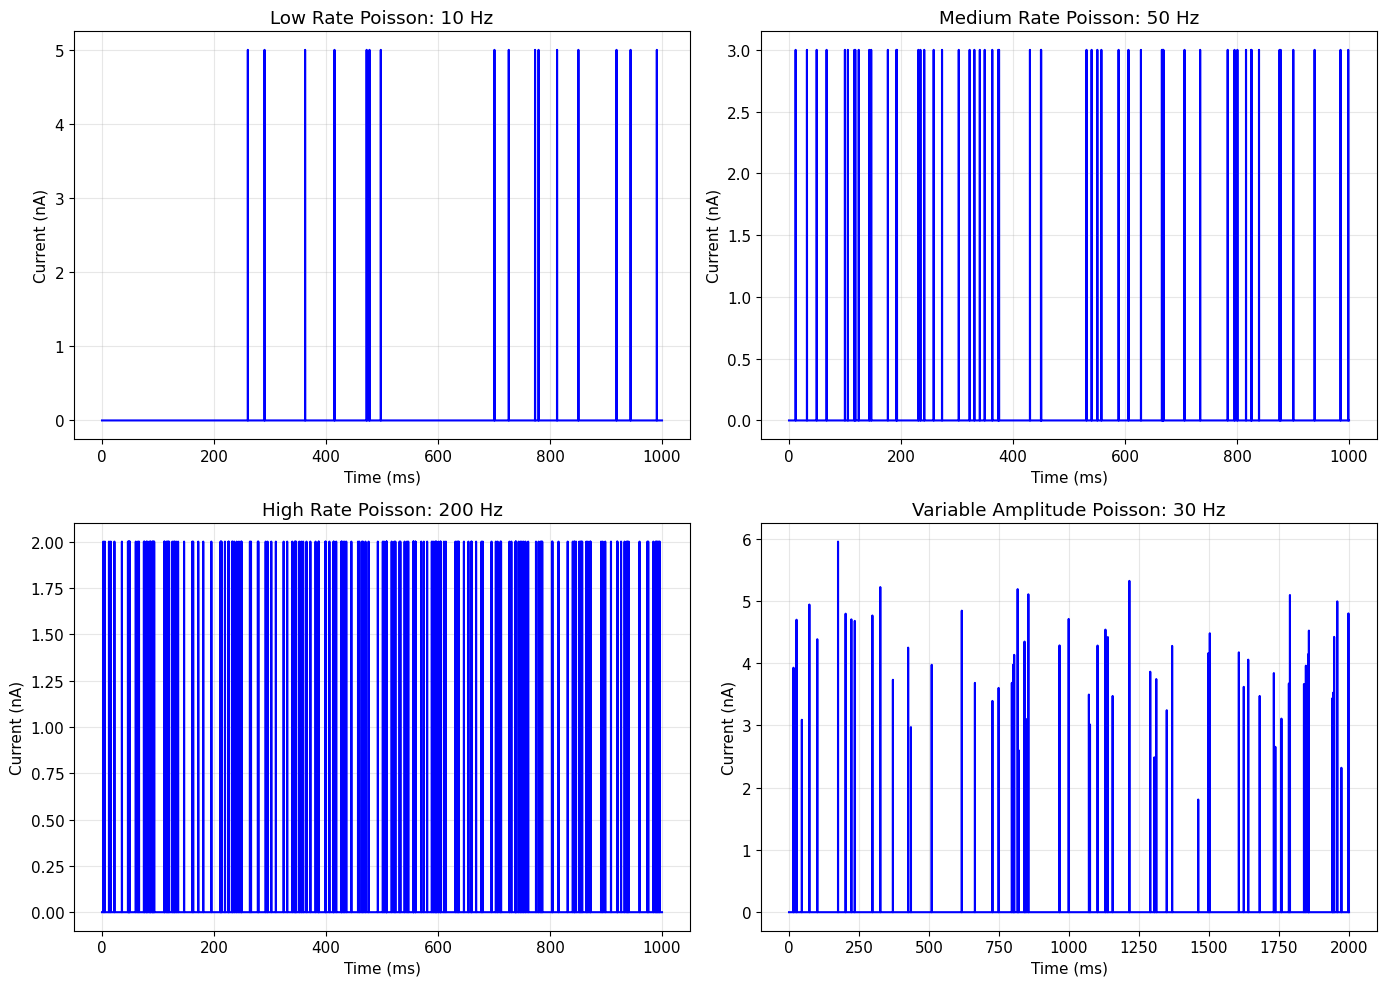

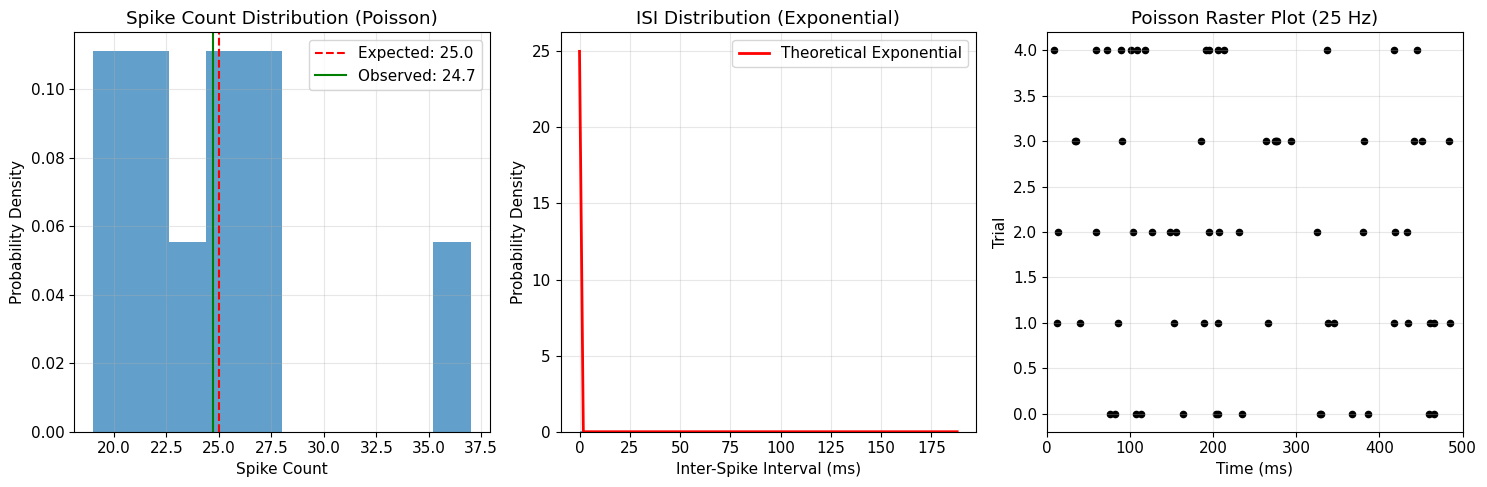

Poisson Statistics (25 Hz, 1000 ms):
Expected spikes per trial: 25.0
Observed mean: 24.7 ± 5.0
Coefficient of variation: 0.20 (should be ~1.0)
Mean ISI: 39.0 ms (expected: 40.0 ms)


In [51]:
with brainstate.environ.context(dt=dt):
    # Low rate Poisson spikes
    low_rate = braintools.input.poisson(amplitude=5.0, rate=10 * u.Hz, duration=1000 * u.ms, seed=42)

    # Medium rate Poisson spikes
    medium_rate = braintools.input.poisson(amplitude=3.0, rate=50 * u.Hz, duration=1000 * u.ms, seed=123)

    # High rate Poisson spikes
    high_rate = braintools.input.poisson(amplitude=2.0, rate=200 * u.Hz, duration=1000 * u.ms, seed=456)

    # Variable amplitude Poisson
    var_poisson = braintools.input.poisson(
        amplitude=np.random.normal(4.0, 1.0, 20000),  # Variable amplitudes
        rate=30 * u.Hz,
        duration=2000 * u.ms,
        seed=789
    )

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_signal(low_rate, 1000 * u.ms, 'Low Rate Poisson: 10 Hz', axes[0])
plot_signal(medium_rate, 1000 * u.ms, 'Medium Rate Poisson: 50 Hz', axes[1])
plot_signal(high_rate, 1000 * u.ms, 'High Rate Poisson: 200 Hz', axes[2])
plot_signal(var_poisson, 2000 * u.ms, 'Variable Amplitude Poisson: 30 Hz', axes[3])

plt.tight_layout()
plt.show()

# Analyze Poisson statistics
# Generate multiple realizations
n_trials = 10
rate = 25 * u.Hz
duration = 1000 * u.ms

spike_counts = []
isis = []  # Inter-spike intervals

for i in range(n_trials):
    poisson_train = braintools.input.poisson(amplitude=1.0, rate=rate, duration=duration, seed=i * 100)

    # Count spikes
    spike_times = np.where(u.get_magnitude(poisson_train) > 0.5)[0] * u.get_magnitude(dt)
    spike_counts.append(len(spike_times))

    # Calculate ISIs
    if len(spike_times) > 1:
        trial_isis = np.diff(spike_times)
        isis.extend(trial_isis)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Spike count distribution
axes[0].hist(spike_counts, bins=10, density=True, alpha=0.7)
expected_count = u.get_magnitude(rate * duration)
axes[0].axvline(expected_count, color='r', linestyle='--',
                label=f'Expected: {expected_count:.1f}')
axes[0].axvline(np.mean(spike_counts), color='g', linestyle='-',
                label=f'Observed: {np.mean(spike_counts):.1f}')
axes[0].set_xlabel('Spike Count')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Spike Count Distribution (Poisson)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ISI distribution
axes[1].hist(isis, bins=30, density=True, alpha=0.7)
# Theoretical exponential distribution
isi_theory = np.linspace(0, max(isis), 100)
rate_val = u.get_magnitude(rate)
exp_theory = rate_val * np.exp(-rate_val * isi_theory)
axes[1].plot(isi_theory, exp_theory, 'r-', linewidth=2,
             label='Theoretical Exponential')
axes[1].set_xlabel('Inter-Spike Interval (ms)')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('ISI Distribution (Exponential)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Sample raster plot
axes[2].set_xlim(0, 500)  # Show first 500 ms
for i in range(5):  # Show first 5 trials
    poisson_train = braintools.input.poisson(amplitude=1.0, rate=rate, duration=500 * u.ms, seed=i * 100)
    spike_times = np.where(u.get_magnitude(poisson_train) > 0.5)[0] * u.get_magnitude(dt)
    axes[2].scatter(spike_times, [i] * len(spike_times), s=20, c='black')

axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Trial')
axes[2].set_title('Poisson Raster Plot (25 Hz)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Poisson Statistics (25 Hz, 1000 ms):")
print(f"Expected spikes per trial: {expected_count:.1f}")
print(f"Observed mean: {np.mean(spike_counts):.1f} ± {np.std(spike_counts):.1f}")
print(f"Coefficient of variation: {np.std(spike_counts) / np.mean(spike_counts):.2f} (should be ~1.0)")
print(f"Mean ISI: {np.mean(isis):.1f} ms (expected: {1000 / rate_val:.1f} ms)")

## 5. Advanced Functional Techniques

Performance optimization and complex protocol generation.

### 5.1 Batch Generation

In [53]:
import time

# Generate multiple sinusoids efficiently
with brainstate.environ.context(dt=dt):
    # Method 1: Loop (slower)
    start_time = time.time()
    frequencies = np.arange(1, 21) * u.Hz  # 1-20 Hz
    sines_loop = []
    for freq in frequencies:
        sine = braintools.input.sinusoidal(1.0, freq, 500 * u.ms)
        sines_loop.append(sine)
    loop_time = time.time() - start_time

    # Method 2: Vectorized (faster for some cases)
    start_time = time.time()
    duration = 500 * u.ms
    dt_val = u.get_magnitude(dt)
    duration_val = u.get_magnitude(duration)
    t = np.arange(0, duration_val, dt_val)

    sines_vectorized = []
    for freq in frequencies:
        freq_val = u.get_magnitude(freq)
        sine = np.sin(2 * np.pi * freq_val * t / 1000) * u.nA
        sines_vectorized.append(sine)
    vectorized_time = time.time() - start_time

print(f"Loop method time: {loop_time:.4f} seconds")
print(f"Vectorized method time: {vectorized_time:.4f} seconds")

# Verify results are similar
diff = np.abs(u.get_magnitude(sines_loop[10]) - u.get_magnitude(sines_vectorized[10]))
print(f"Maximum difference: {np.max(diff):.2e}")

Loop method time: 0.0033 seconds
Vectorized method time: 0.0050 seconds
Maximum difference: 2.98e-08


### 5.2 Complex Protocol Assembly

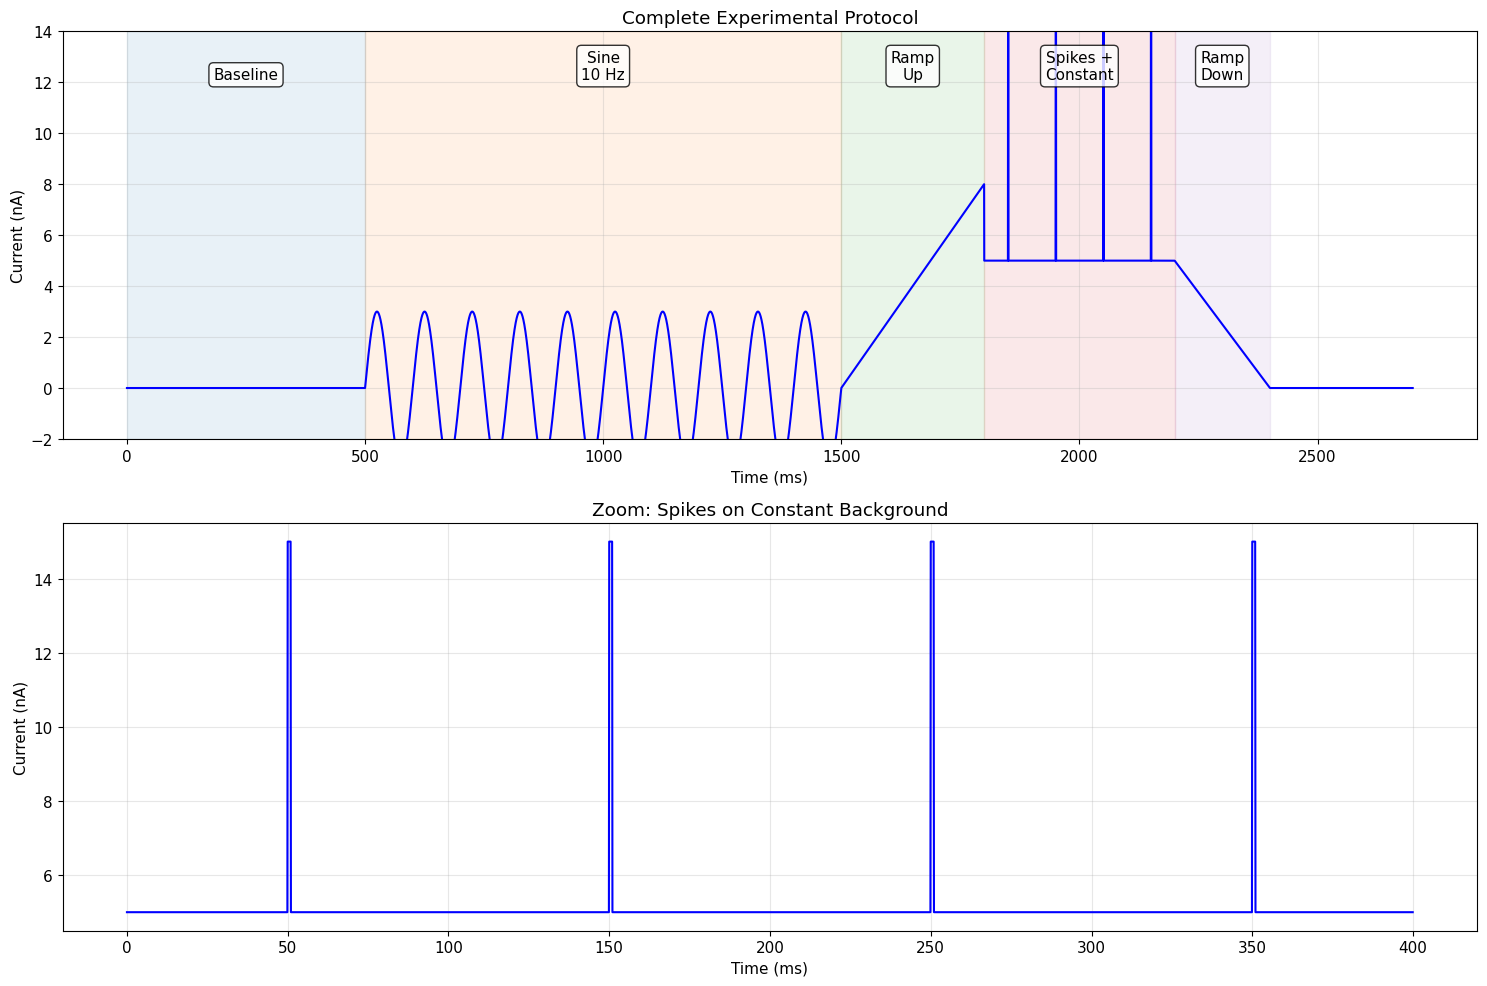

Protocol duration: 2700 ms
Array length: 27000 points
Memory usage: ~210.9 KB


In [58]:
# Build a complex experimental protocol using functional API
with brainstate.environ.context(dt=dt):
    # Protocol: baseline + sine + ramp + spikes + recovery

    # Phase 1: Baseline (500 ms)
    baseline = braintools.input.constant([(0, 500 * u.ms)])[0]

    # Phase 2: Sinusoidal stimulation (1000 ms, 10 Hz)
    sine_stim = braintools.input.sinusoidal(3.0, 10 * u.Hz, 1000 * u.ms)

    # Phase 3: Ramp up (300 ms, 0 to 8 nA)
    ramp_up = braintools.input.ramp(0, 8, 300 * u.ms)

    # Phase 4: Brief spikes on top of constant (400 ms)
    constant_bg = braintools.input.constant([(5, 400 * u.ms)])[0]
    spike_times = [50, 150, 250, 350] * u.ms
    spikes = braintools.input.spike(spike_times, 1. * u.ms, 10.0, 400 * u.ms)
    spikes_on_constant = constant_bg + spikes

    # Phase 5: Recovery ramp (200 ms, 5 to 0 nA)
    ramp_down = braintools.input.ramp(5, 0, 200 * u.ms)

    # Phase 6: Final baseline (300 ms)
    final_baseline = braintools.input.constant([(0, 300 * u.ms)])[0]

    # Assemble complete protocol
    complete_protocol = np.concatenate([
        baseline,
        sine_stim,
        ramp_up,
        spikes_on_constant,
        ramp_down,
        final_baseline
    ])

    total_duration = 500 + 1000 + 300 + 400 + 200 + 300  # 2700 ms

# Plot the complete protocol
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Full protocol
plot_signal(complete_protocol, total_duration * u.ms, 'Complete Experimental Protocol', ax1)

# Zoomed view of spike phase
spike_start = int((500 + 1000 + 300) / u.get_magnitude(dt))
spike_end = int((500 + 1000 + 300 + 400) / u.get_magnitude(dt))
spike_phase = complete_protocol[spike_start:spike_end]
plot_signal(spike_phase, 400 * u.ms, 'Zoom: Spikes on Constant Background', ax2)

# Add phase annotations
phase_starts = [0, 500, 1500, 1800, 2200, 2400]
phase_labels = ['Baseline', 'Sine\n10 Hz', 'Ramp\nUp', 'Spikes +\nConstant', 'Ramp\nDown', 'Recovery']

for i, (start, label) in enumerate(zip(phase_starts[:-1], phase_labels)):
    end = phase_starts[i + 1]
    ax1.axvspan(start, end, alpha=0.1, color=f'C{i}')
    ax1.text(start + (end - start) / 2, 12, label, ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax1.set_ylim(-2, 14)

plt.tight_layout()
plt.show()

print(f"Protocol duration: {total_duration} ms")
print(f"Array length: {len(complete_protocol)} points")
print(f"Memory usage: ~{len(complete_protocol) * 8 / 1024:.1f} KB")

### 5.3 Parameter Sweeps

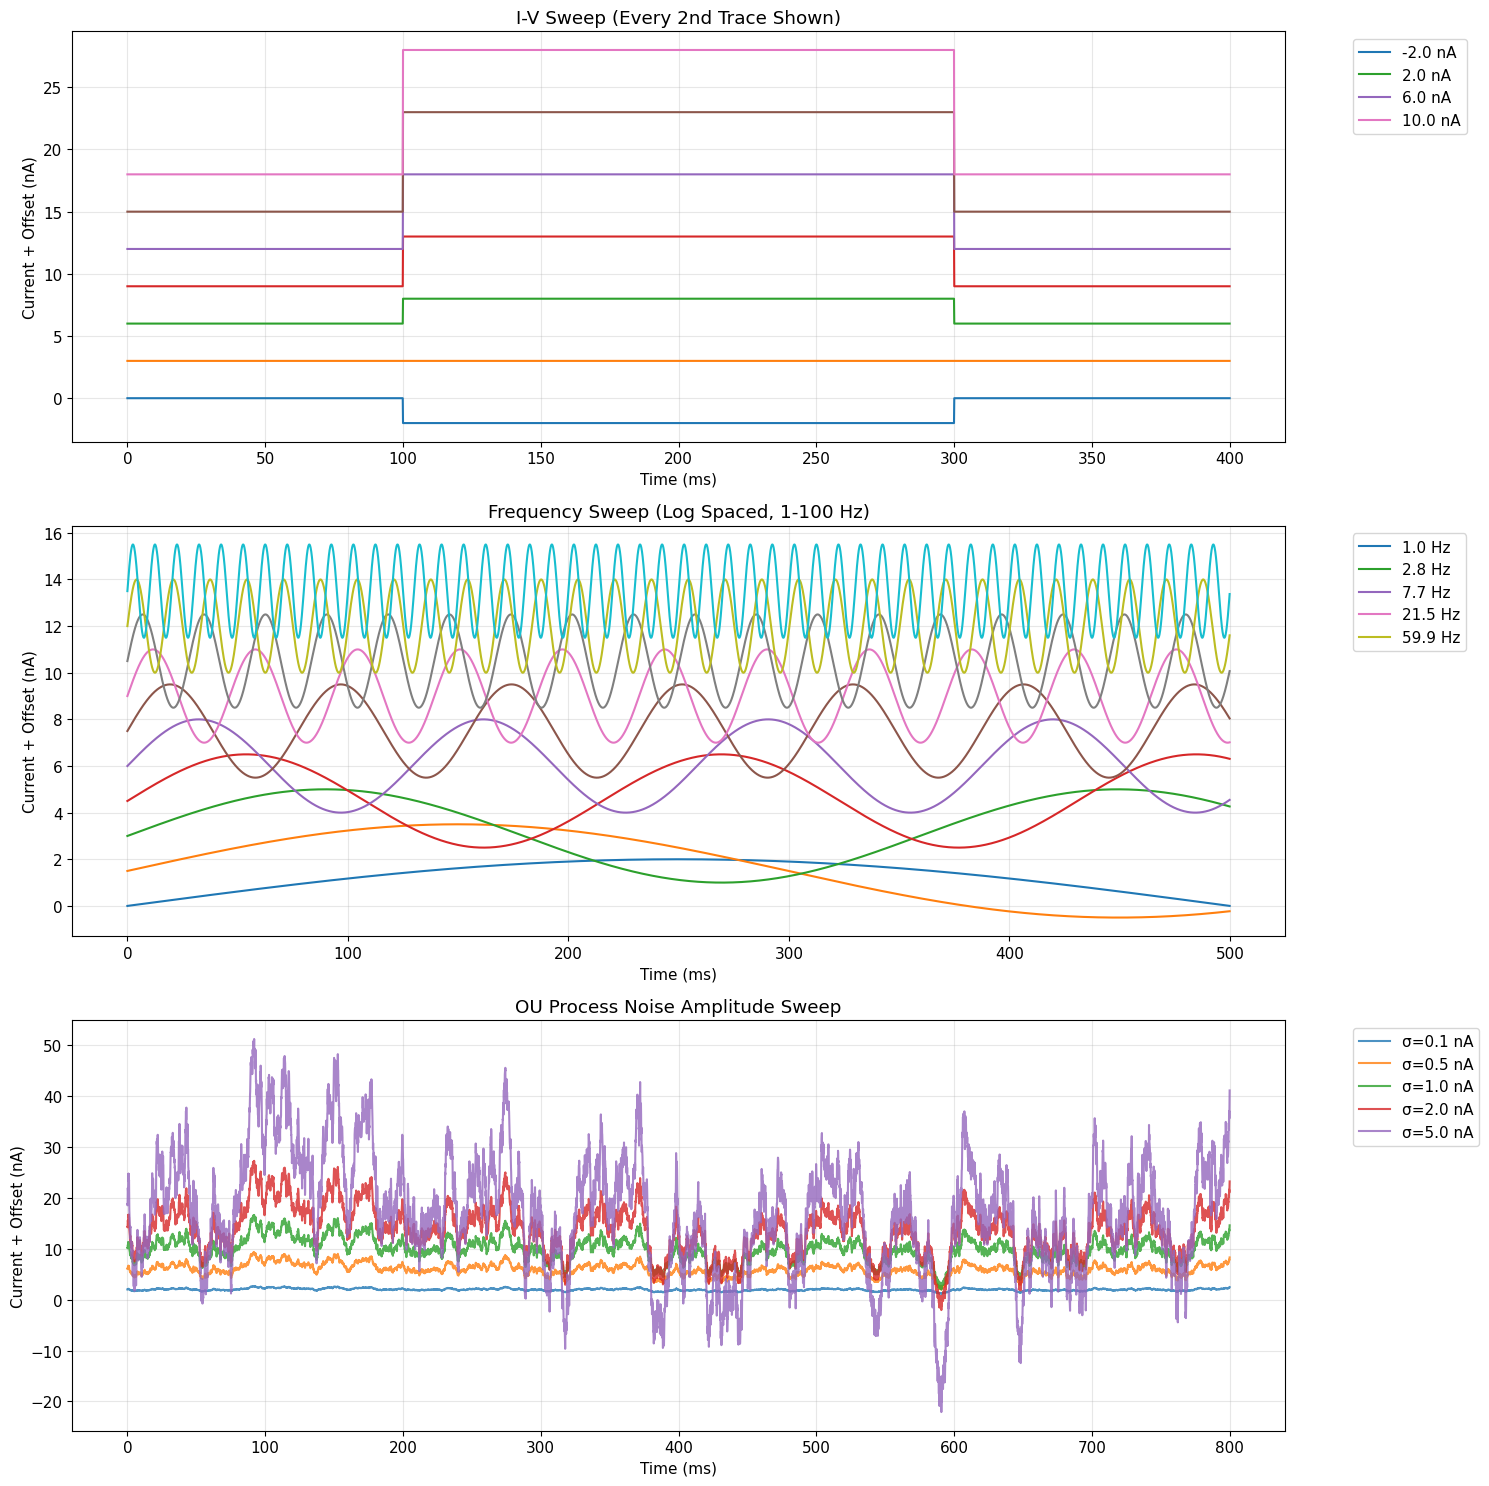

Generated 13 I-V traces
Generated 10 frequency responses
Generated 5 noise conditions
Frequency range: 1.0 - 100.0 Hz


In [60]:
# Generate parameter sweeps for systematic studies
with brainstate.environ.context(dt=dt):
    # Amplitude sweep for I-V curves
    amplitudes = np.linspace(-2, 10, 13)  # -2 to 10 nA in 13 steps
    iv_sweeps = []
    for amp in amplitudes:
        # Each sweep: 100ms baseline + 200ms step + 100ms recovery
        iv_sweeps.append(
            braintools.input.section([0, amp, 0], [100, 200, 100] * u.ms)
        )

    # Frequency sweep for resonance testing
    frequencies = np.logspace(0, 2, 10) * u.Hz  # 1 to 100 Hz, log spaced
    freq_sweeps = []
    for freq in frequencies:
        freq_sweeps.append(
            braintools.input.sinusoidal(2.0, freq, 500 * u.ms)
        )

    # Noise amplitude sweep
    noise_sigmas = [0.1, 0.5, 1.0, 2.0, 5.0]
    noise_sweeps = []
    for sigma in noise_sigmas:
        # OU process with constant mean
        noise_sweeps.append(
            braintools.input.ou_process(sigma=sigma, tau=10 * u.ms, mean=2.0, duration=800 * u.ms, seed=42)
        )

# Visualize parameter sweeps
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# I-V sweep waterfall plot
ax = axes[0]
for i, (sweep, amp) in enumerate(zip(iv_sweeps[::2], amplitudes[::2])):
    time_points = np.arange(0, 400, u.get_magnitude(dt))
    offset = i * 3  # Vertical offset
    ax.plot(time_points, u.get_magnitude(sweep) + offset,
            label=f'{amp:.1f} nA' if i % 2 == 0 else '')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current + Offset (nA)')
ax.set_title('I-V Sweep (Every 2nd Trace Shown)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Frequency sweep spectrogram-style
ax = axes[1]
for i, (sweep, freq) in enumerate(zip(freq_sweeps, frequencies)):
    time_points = np.arange(0, 500, u.get_magnitude(dt))
    offset = i * 1.5
    ax.plot(time_points, u.get_magnitude(sweep) + offset,
            label=f'{u.get_magnitude(freq):.1f} Hz' if i % 2 == 0 else '')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current + Offset (nA)')
ax.set_title('Frequency Sweep (Log Spaced, 1-100 Hz)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Noise amplitude sweep
ax = axes[2]
for i, (noise, sigma) in enumerate(zip(noise_sweeps, noise_sigmas)):
    time_points = np.arange(0, 800, u.get_magnitude(dt))
    offset = i * 4
    ax.plot(time_points, u.get_magnitude(noise) + offset, alpha=0.8,
            label=f'σ={sigma} nA')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current + Offset (nA)')
ax.set_title('OU Process Noise Amplitude Sweep')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Generated {len(iv_sweeps)} I-V traces")
print(f"Generated {len(freq_sweeps)} frequency responses")
print(f"Generated {len(noise_sweeps)} noise conditions")
print(f"Frequency range: {u.get_magnitude(frequencies[0]):.1f} - {u.get_magnitude(frequencies[-1]):.1f} Hz")

## 6. Real-World Applications

Examples of experimental protocols you might actually use.

### 6.1 Patch Clamp Protocols

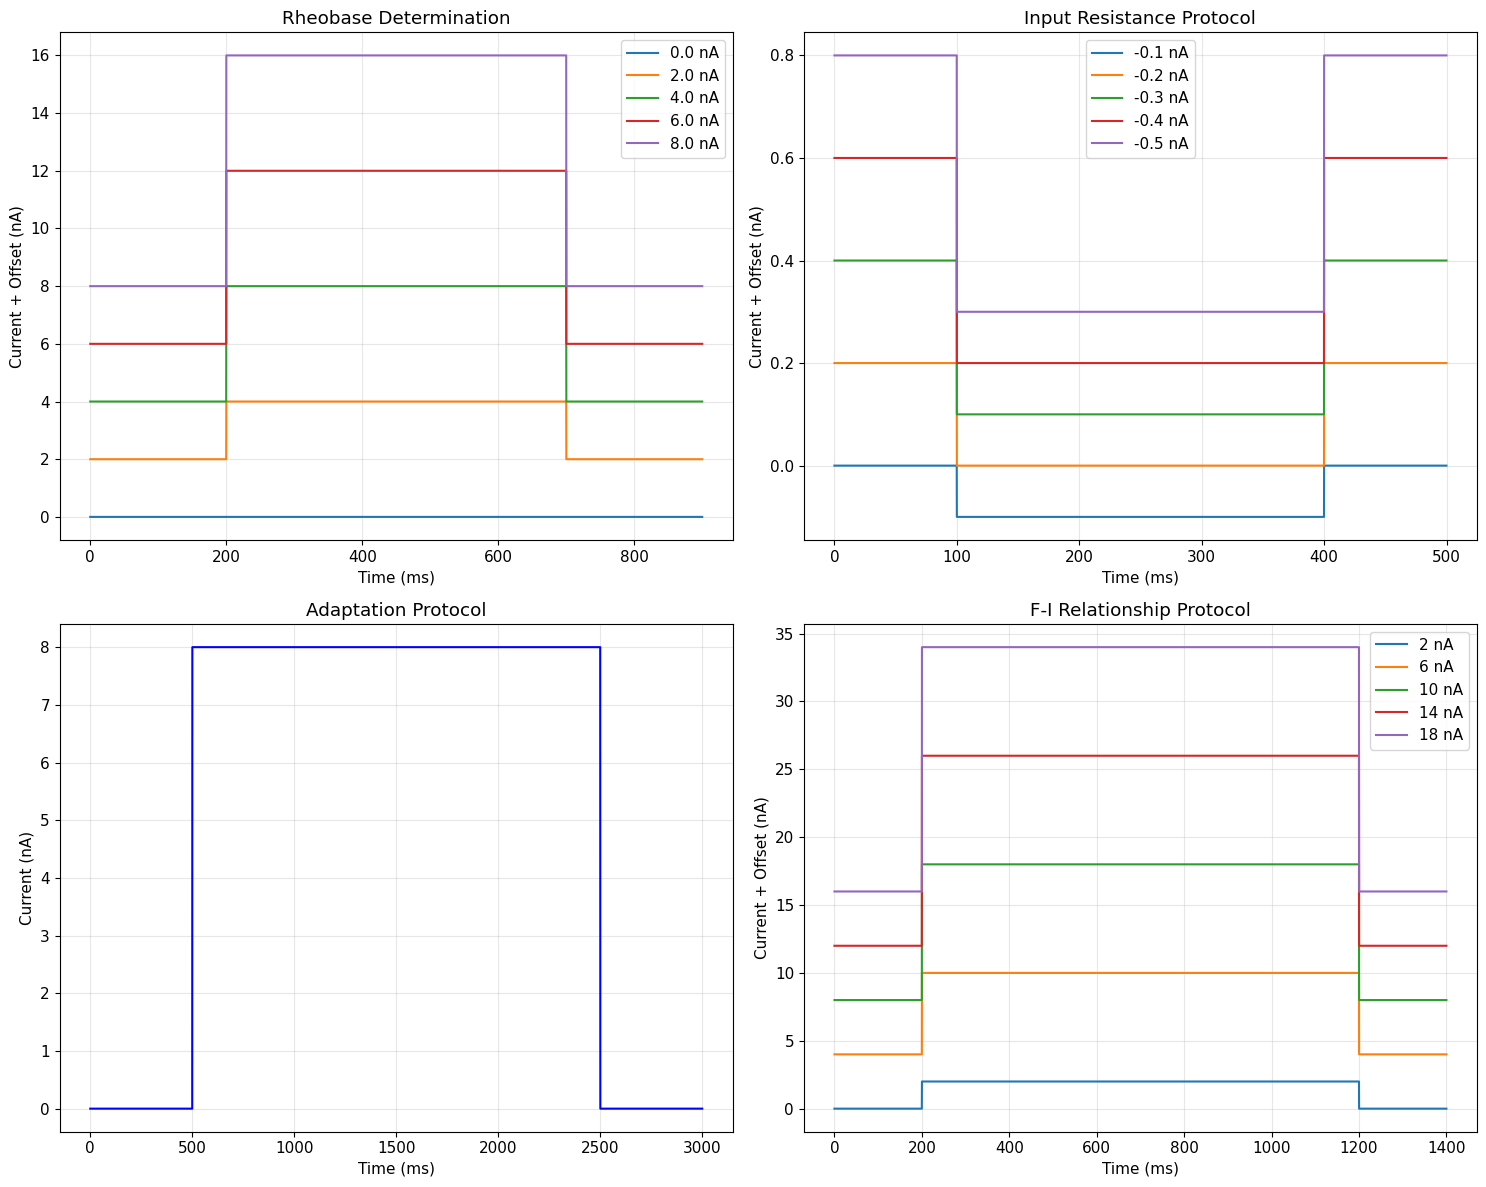

Generated 20 rheobase protocols
Generated 5 input resistance protocols
Generated 9 F-I protocols
Total protocols: 35


In [61]:
# Standard patch clamp protocols using functional API

with brainstate.environ.context(dt=dt):
    # 1. Rheobase determination (find threshold current)
    rheobase_currents = np.arange(0, 10, 0.5)  # 0 to 10 nA in 0.5 nA steps
    rheobase_protocols = []

    for current in rheobase_currents:
        protocol = braintools.input.constant([
            (0, 200 * u.ms),  # baseline
            (current, 500 * u.ms),  # test current
            (0, 200 * u.ms)  # recovery
        ])[0]
        rheobase_protocols.append(protocol)

    # 2. Input resistance measurement
    # Small hyperpolarizing steps to stay in linear range
    test_currents = [-0.1, -0.2, -0.3, -0.4, -0.5]  # Small negative currents
    rin_protocols = []

    for current in test_currents:
        protocol = braintools.input.constant([
            (0, 100 * u.ms),
            (current, 300 * u.ms),
            (0, 100 * u.ms)
        ])[0]
        rin_protocols.append(protocol)

    # 3. Adaptation protocol
    adaptation_protocol = braintools.input.constant([
        (0, 500 * u.ms),  # baseline
        (8, 2000 * u.ms),  # long depolarizing step
        (0, 500 * u.ms)  # recovery
    ])[0]

    # 4. Frequency-current (F-I) relationship
    fi_currents = np.arange(2, 20, 2)  # 2 to 18 nA in 2 nA steps
    fi_protocols = []

    for current in fi_currents:
        protocol = braintools.input.constant([
            (0, 200 * u.ms),
            (current, 1000 * u.ms),  # 1 second for rate measurement
            (0, 200 * u.ms)
        ])[0]
        fi_protocols.append(protocol)

# Plot representative protocols
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Rheobase (show every 4th trace)
ax = axes[0, 0]
for i in range(0, len(rheobase_protocols), 4):
    time_points = np.arange(0, 900, u.get_magnitude(dt))
    offset = i * 0.5
    ax.plot(time_points, u.get_magnitude(rheobase_protocols[i]) + offset,
            label=f'{rheobase_currents[i]:.1f} nA')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current + Offset (nA)')
ax.set_title('Rheobase Determination')
ax.legend()
ax.grid(True, alpha=0.3)

# Input resistance
ax = axes[0, 1]
for i, (protocol, current) in enumerate(zip(rin_protocols, test_currents)):
    time_points = np.arange(0, 500, u.get_magnitude(dt))
    offset = i * 0.2
    ax.plot(time_points, u.get_magnitude(protocol) + offset,
            label=f'{current:.1f} nA')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current + Offset (nA)')
ax.set_title('Input Resistance Protocol')
ax.legend()
ax.grid(True, alpha=0.3)

# Adaptation
plot_signal(adaptation_protocol, 3000 * u.ms, 'Adaptation Protocol', axes[1, 0])

# F-I relationship (show subset)
ax = axes[1, 1]
for i in range(0, len(fi_protocols), 2):
    time_points = np.arange(0, 1400, u.get_magnitude(dt))
    offset = i * 2
    ax.plot(time_points, u.get_magnitude(fi_protocols[i]) + offset,
            label=f'{fi_currents[i]:.0f} nA')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current + Offset (nA)')
ax.set_title('F-I Relationship Protocol')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Generated {len(rheobase_protocols)} rheobase protocols")
print(f"Generated {len(rin_protocols)} input resistance protocols")
print(f"Generated {len(fi_protocols)} F-I protocols")
print(f"Total protocols: {len(rheobase_protocols) + len(rin_protocols) + len(fi_protocols) + 1}")

### 6.2 Dynamic Clamp Simulation

In [72]:
import functools

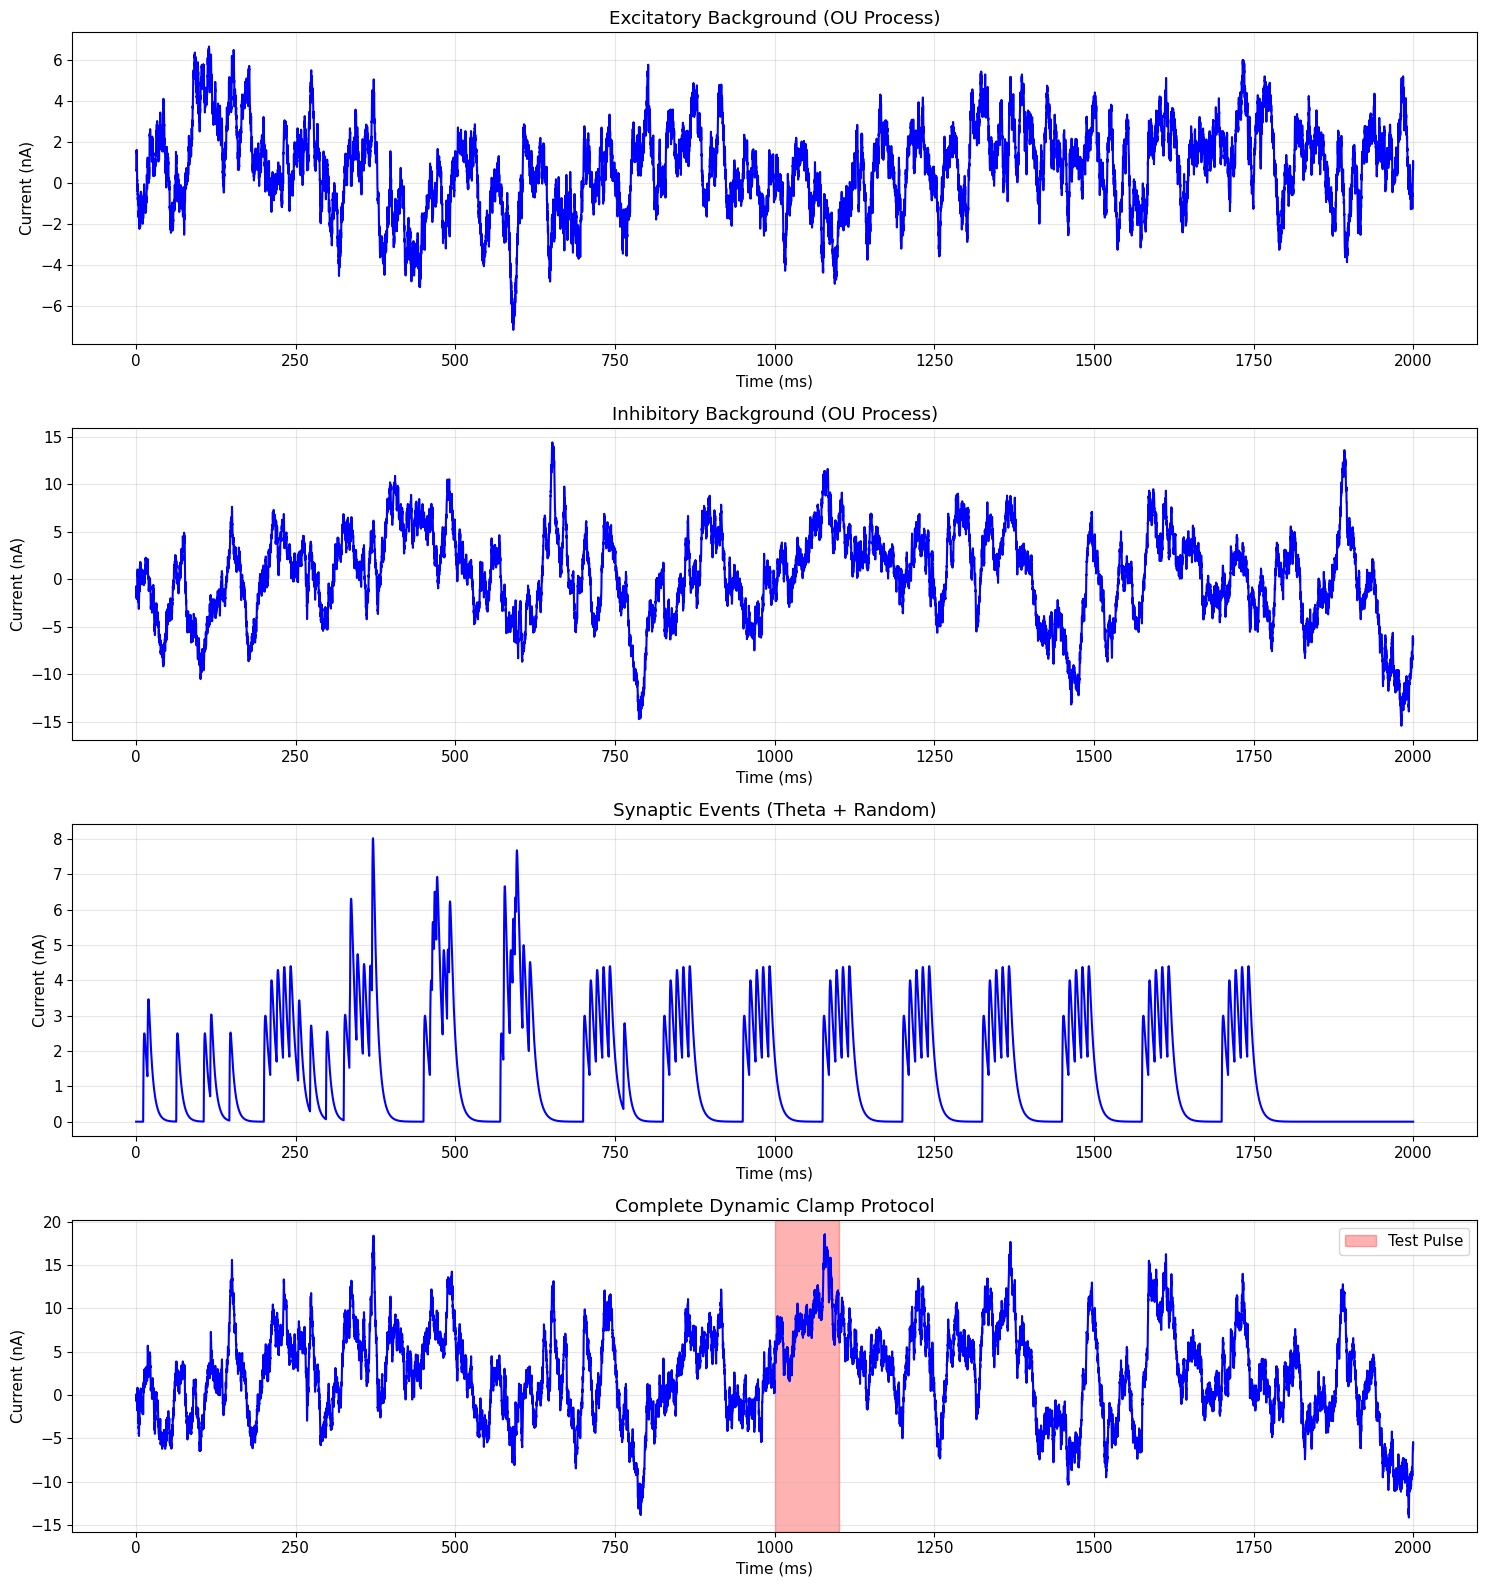

Dynamic Clamp Statistics:
Excitatory background: 0.72 ± 2.05 nA
Inhibitory background: 0.22 ± 4.69 nA
Total current range: -14.12 to 18.57 nA
Number of theta events: 13
Number of random EPSCs: 28


In [79]:
with brainstate.environ.context(dt=dt):
      duration = 2000 * u.ms

      # 1. Background synaptic activity (OU process)
      # Fixed: Corrected parameter order (mean, sigma, tau, duration)
      excitatory_bg = braintools.input.ou_process(
          mean=0.5, sigma=0.8, tau=15 * u.ms, duration=duration, seed=42
      ) * u.nA

      inhibitory_bg = braintools.input.ou_process(
          mean=-0.8, sigma=1.2, tau=25 * u.ms, duration=duration, seed=123
      ) * u.nA

      # 2. Periodic excitatory inputs (theta rhythm)
      theta_times = np.arange(200, 1800, 125)  # 8 Hz theta (in ms)
      theta_inputs = []
      for t in theta_times:
          # Each theta event triggers multiple gamma spikes
          gamma_times = t + np.array([0, 10, 20, 30, 40])  # in ms
          for gt in gamma_times:
              if gt < u.get_magnitude(duration):
                  # Fixed: Corrected parameter order (amplitude, tau_rise, tau_decay, duration, t_start)
                  epsc = braintools.input.double_exponential(
                      amplitude=3.0,
                      tau_rise=1 * u.ms,
                      tau_decay=8 * u.ms,
                      duration=duration,
                      t_start=gt * u.ms
                  )
                  theta_inputs.append(epsc)

      # Sum all theta inputs - Fixed: Proper array handling
      if theta_inputs:
          theta_total = functools.reduce(lambda a, b: a + b, theta_inputs) * u.nA
      else:
          theta_total = np.zeros(int(u.get_magnitude(duration) / 0.05)) * u.nA

      # 3. Random excitatory events (Poisson)
      poisson_spikes = braintools.input.poisson(
          rate=15 * u.Hz,
          duration=duration,
          amplitude=1.0,
          seed=456
      )

      # Convert spikes to EPSCs
      spike_indices = np.where(u.get_magnitude(poisson_spikes) > 0.5)[0]
      spike_times = spike_indices * 0.05  # Convert to ms (assuming dt = 0.05 ms)
      random_epscs = []

      for st in spike_times[:20]:  # Limit for performance
          if st < u.get_magnitude(duration):
              epsc = braintools.input.double_exponential(
                  amplitude=2.5,
                  tau_rise=0.8 * u.ms,
                  tau_decay=6 * u.ms,
                  duration=duration,
                  t_start=st * u.ms
              )
              random_epscs.append(epsc)

      if random_epscs:
          random_total = functools.reduce(lambda a, b: a + b, random_epscs) * u.nA
      else:
          random_total = np.zeros(int(u.get_magnitude(duration) / 0.05)) * u.nA

      # 4. Combine all inputs
      total_current = excitatory_bg + inhibitory_bg + theta_total + random_total

      # 5. Add a brief test pulse
      # Fixed: Corrected section function usage (values, durations)
      test_pulse = braintools.input.section(
          values=[0, 5, 0],
          durations=[1000 * u.ms, 100 * u.ms, 900 * u.ms]
      ) * u.nA

      final_protocol = total_current + test_pulse

# Plot the dynamic clamp simulation
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Individual components
plot_signal(excitatory_bg, duration, 'Excitatory Background (OU Process)', axes[0])
plot_signal(inhibitory_bg, duration, 'Inhibitory Background (OU Process)', axes[1])
plot_signal(theta_total + random_total, duration, 'Synaptic Events (Theta + Random)', axes[2])
plot_signal(final_protocol, duration, 'Complete Dynamic Clamp Protocol', axes[3])

# Mark test pulse
axes[3].axvspan(1000, 1100, alpha=0.3, color='red', label='Test Pulse')
axes[3].legend()

plt.tight_layout()
plt.show()

# Statistics
print("Dynamic Clamp Statistics:")
print(
  f"Excitatory background: {np.mean(u.get_magnitude(excitatory_bg)):.2f} ± {np.std(u.get_magnitude(excitatory_bg)):.2f} nA"
)
print(
  f"Inhibitory background: {np.mean(u.get_magnitude(inhibitory_bg)):.2f} ± {np.std(u.get_magnitude(inhibitory_bg)):.2f} nA"
)
print(
  f"Total current range: {np.min(u.get_magnitude(final_protocol)):.2f} to {np.max(u.get_magnitude(final_protocol)):.2f} nA"
)
print(f"Number of theta events: {len(theta_times)}")
print(f"Number of random EPSCs: {len(spike_times)}")